# Workflow afin de réaliser des variogrammes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import rasterio as rio
from tools_AA_IR import get_tif, reading_gps_file
from tools_AA import slice_raw, path_sonde
from tools_EL import readingtemp
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.shutil import delete
from numba import jit
import geostatspy.geostats as geostats 

`pip install numba` dans le cas où on veut utiliser l'optimisation

In [59]:
def alternate_variogram(X,Y,Z,width,leng,direction = 45,angle_tolerance = 22.5) :
    """
    Fonction de calcul de variogramme en prenant en compte anisotropie. Un angle de tolérance est appliqué pour 
    tout calcul autout d'une direction donnée 
    """
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    
    for ii in np.arange(0,n):
        value_df = pd.DataFrame()
        value_df["X"] = X
        value_df["X0"] = X[ii]
        value_df["Y"] = Y
        value_df["Y0"] = Y[ii]
        value_df["Z"] = Z
        value_df["Z0"] = Z[ii]
        
        # distance et angle par rapport au point d'observation
        value_df["dist"]  = np.sqrt(((value_df["X"]-value_df["X0"]))**2+(value_df["Y"]-value_df["Y0"])**2)
        value_df["theta"] = np.arctan2(value_df["Y"]-value_df["Y0"],value_df["X"]-value_df["X0"])* (180/np.pi)
        value_df["theta"].loc[value_df["theta"] < 0 ] = 180 + 180-np.absolute(value_df["theta"])

        if (direction + angle_tolerance) < 360 :
            exp  = "theta >= " + str(direction - angle_tolerance) +" & "
            exp += "theta <= " + str(direction + angle_tolerance)+" & " + "dist < " +str(L) 
            value = value_df.query(exp)
            selected_value = value.copy() # remove warning 


        elif (direction + angle_tolerance) > 360 : 
            exp  = "theta >= " + str(direction) +" or " 
            exp += "theta <= " + str((0 + (angle_tolerance-(360-direction))))+" & " + "dist < " +str(L)
            selected_value = value_df.query(exp) 
            value = value_df.query(exp)
            selected_value = value.copy()

        else :
            exp = "theta >= " + str((360 - np.absolute(angle_tolerance - direction ))) +" or "+ "theta <= " + str(direction  + angle_tolerance)+" & " + "dist < " +str(L) 
            selected_value = value_df.query(exp)
            value = value_df.query(exp)
            selected_value = value.copy() 

        selected_value["index"] = np.array(selected_value["dist"] /w,dtype = int)
        selected_value["dZ"] = (selected_value["Z0"]-selected_value["Z"])**2    

        for index in np.arange(0,nlag) :
            dev[index] = dev[index]+ selected_value.query("index == "+str(index + 1 ))["dZ"].values.sum() 
            counts[index] = counts[index]+ selected_value.query("index == "+str(index + 1 ))["index"].count()
    
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam
    

In [60]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 10000 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

In [61]:
def direction_angle_test(X,Y,Z, INDICE,width,leng,direction = 45,theta_tolerance = 22.5) :
    """
    Permet de tester et voir les valeurs choisient en fonction de la direction +/- angle de tolérance
    """
    n=len(X)
    nlag=np.int(np.fix(leng/width)) # 25, nombre de lag généré, fix : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
        
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    theta = []
    #theta_tolerance = 22.5
    #direction       = 45
    index_dict = {}
    
    for ii in [INDICE]:
        index = []
        for jj in np.arange(0,n): 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng):
                # Ajout de la direction 
                
                if (direction + angle_tolerance) < 360 :
                    if (tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance)) :
                        index.append(jj)
                        
                elif (direction + angle_tolerance) > 360 : 
                    if tht >= (direction) or tht <= (0 + (angle_tolerance-(360-direction))) :
                        index.append(jj)
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index.append(jj)
                    
        index_dict[ii] = index
            
    return index_dict
    

In [62]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        #print("completed :",name)
    
    return dict_temp_sensor

    

In [63]:
def reading_all_IR(filetif,ls_path_tif,ech = 1000) :
    """
    filetif : nom de l'IR en cas de dictionnaire
    ls_path_tif : chemin d'accès du fichier .tif
    ech : echantillonage
    Fait la conversion d'un fichier tif en DataFrame contenant les coordonnées (x,y)
    """
    dict_IR = {}
    filetif_cluster = "./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif"
    for kk,path_tif in enumerate(ls_path_tif) :
        with rio.open(path_tif) as dataset :
            dataset_cluster = rio.open(filetif_cluster)
            print(filetif[kk],ls_path_tif[kk])
            st1 = timeit.default_timer()

            all_band= dataset.read(1)
            win_transform = dataset.transform
            extent = plotting_extent(all_band,win_transform)
            width  = dataset.width
            height = dataset.height

            x_start = win_transform[2]
            x_res   = win_transform[0]
            x_end   = x_start+(float(x_res)*dataset.width)

            y_end   = win_transform[5]
            y_res   = win_transform[4]
            y_start = y_end + (float(y_res)*dataset.height)

            x = np.linspace(x_start,x_end,num = width+1)
            x = x[0:-1] # Permet de supprimer la dernière value incorrecte ?  
            y = np.linspace(y_start,y_end,num = height+1)
            y = y[0:-1] # Permet de supprimer la dernière value incorrecte ? 
            band_1 = []
            x_matrix = []
            y_matrix = []
            count = 0
            for ii in range(len(x)) :        
                for jj in range(len(y)) :
                    count +=1
                    if count == ech :
                        for val in dataset.sample([(x[ii],y[jj])]):
                            #print("ii :",ii,"jj :",jj,"count :",count)
                            band_1.append(float(val))
                            x_matrix.append(x[ii]) 
                            y_matrix.append(y[jj])
                        count = 0
                        
        mapping = ['X','Y','band 1']            
        Data_df = pd.DataFrame(np.array([x_matrix,
                                             y_matrix,
                                             band_1],dtype = float).T,
                                   columns=mapping)
            
        Data_df["band 1"] = Data_df["band 1"].replace(1.0,np.NAN)
        #Data_df = Data_df.dropna()
        # Transformation Normal Score
        Data_df["Secondary"] = (Data_df["band 1"] - Data_df["band 1"].mean())/Data_df["band 1"].std()
        dict_IR["IR_"+filetif[kk]] = {"Secondary" : Data_df,
                                     "echantillonage" : ech,
                                     "width" : width ,
                                      "height" : height}

    return dict_IR

        

In [64]:
def reading_IR_only_sensor(filetif,ls_path_tif,ls_fileout_vis,ls_fileout_hsv,Sensor_df,ech = 100) :
    """
    filetif : nom de l'IR en cas de dictionnaire
    ls_path_tif : chemin d'accès du fichier .tif
    ech : echantillonage
     Fait la conversion d'un fichier tif en DataFrame contenant les coordonnées (x,y)
     dans un espace convexe associé aux limites des sondes
    """
    dict_IR = {}
    ## Initialisation des constantes 
    marge = 10 # longueur (m) à rajouter aux extrémités
    for kk,path_tif in enumerate(ls_path_tif) :
        print(filetif[kk])
        with rio.open(path_tif) as dataset :
            with rio.open(ls_fileout_vis[kk]) as dataset_cluster_vis :
                with rio.open(ls_fileout_hsv[kk]) as dataset_cluster_hsv :

                    win_transform = dataset.transform
                    x_start = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["x"].values.astype(float)[0]-marge 
                    x_res   = win_transform[0]
                    x_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["x"].values.astype(float)[0]+marge
                    width   = int(np.absolute(x_end - x_start) / x_res) + 1

                    y_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["y"].values.astype(float)[0]+marge
                    y_res   = win_transform[4]
                    y_start = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["y"].values.astype(float)[0]-marge
                    height  = int(np.absolute(y_end - y_start) / np.absolute(y_res)) + 1
                    x = np.linspace(x_start,x_end,num = width)
                    y = np.linspace(y_start,y_end,num = height)
                    band_1 = []
                    x_matrix = []
                    y_matrix = []
                    cluster_vis_matrix = []
                    cluster_hsv_matrix = []
                    count = 0 # compteur d'echantillonage
                    for ii in range(len(x)) :        
                        for jj in range(len(y)) :
                            count +=1
                            if count == ech :
                                for val in dataset.sample([(x[ii],y[jj])]):
                                    #print("ii :",ii,"jj :",jj,"count :",count)
                                    band_1.append(float(val))
                                    x_matrix.append(x[ii]) 
                                    y_matrix.append(y[jj])

                                for val_cluster_vis in dataset_cluster_vis.sample([(x[ii],y[jj])]):
                                    cluster_vis_matrix.append(val_cluster_vis)

                                for val_cluster_hsv in dataset_cluster_hsv.sample([(x[ii],y[jj])]):
                                    cluster_hsv_matrix.append(val_cluster_hsv)
                                count = 0
                        
        mapping = ['X','Y','band 1',"cluster_label_vis","val_cluster_hsv"]            
        Data_df = pd.DataFrame(np.array([x_matrix,y_matrix,band_1,cluster_vis_matrix,cluster_hsv_matrix],dtype = float).T,
                                   columns=mapping)
            
        Data_df["band 1"] = Data_df["band 1"].replace(1.0,np.NAN)
        #Data_df = Data_df.dropna()
        # Transformation Normal Score
        Data_df["Secondary"] = (Data_df["band 1"] - Data_df["band 1"].mean())/Data_df["band 1"].std()
        dict_IR["IR_"+filetif[kk]] = {"Secondary" : Data_df,
                                     "echantillonage" : ech,
                                     "width" : width,
                                     "height" : height}

    ## Supprime le .tif crée
    for fileout_cluster in ls_fileout_vis : 
        rio.shutil.delete(fileout_cluster)
    for fileout_cluster in ls_fileout_hsv : 
        rio.shutil.delete(fileout_cluster)
        
    return dict_IR

        

In [65]:
def Re_sampling_function(filetif_dataset,ls_filetif_res,filetif,label = "vis") :
    """
    Re-sampling avec un fichier temporaire "sampled.tif" qui permet de faire correspondre deux .tif avec comme
    base la résolution (x,y) du pixel
    filetif_dataset : chemin d'accès du .tif à re-sampler
    filetif_res : chemin d'accès du '.tif' à la résolution (x,y) cible
    
    """
    ls_fileout = []
    for kk,filetif_res in enumerate(ls_filetif_res) : 
        ## On récupère la résolution cible
        with rio.open(filetif_res) as dataset_res :
                #print("dataset_res : ",dataset_res.res)
                res_x = dataset_res.res[0]
                res_y = dataset_res.res[1]

        ## On récupère le dataset cible
        with rio.open(filetif_dataset) as dataset :
                #print("dataset : ",dataset.res)
                res_dataset_x = dataset.res[0]
                res_dataset_y = dataset.res[1]

                # Facteurs liés au resampling 
                upscale_factor_height = res_dataset_y / res_y
                upscale_factor_width = res_dataset_x / res_x

                # resample data to target shape
                data = dataset.read(
                    out_shape=(
                        dataset.count,
                        int(dataset.height * upscale_factor_height),
                        int(dataset.width * upscale_factor_width)),
                    resampling=Resampling.bilinear
                )

                # scale image transform
                transform = dataset.transform * dataset.transform.scale(
                    (dataset.width / data.shape[-1]),
                    (dataset.height / data.shape[-2])
                )

                # Save the new profile & .tif
                profile = {
                    "driver": "GTiff",
                    "count": 1,
                    "height": int(dataset.height * upscale_factor_height),
                    "width": int(dataset.width * upscale_factor_width),
                    "dtype": "uint8",
                    "transform": transform,
                    "bounds": dataset.bounds,
                    "crs": dataset.crs,
                    "res": (transform[0],transform[4])
                }
                # Filepath 
                fileout = "./traitement_PIREN/sampled_"+str(label)+"_"+str(filetif[kk])+".tif"
                print("new shape :", data.shape[1:3])
                with rio.open(fileout,"w",**profile) as dataset_sample :
                    dataset_sample.write(data)
                    print("Completed, new file can be found :",fileout)
                    ls_fileout.append(fileout)
                
    return ls_fileout
            

# Importation des données du drone (Y)

# Création d'un espace réduit autour des sondes (convex)

### Toutes les IR
Ajout des labels de clusterings HSV et VIS re-samplend pour convenir aux thermo-mosaïques 

In [21]:
Condition = True 
if Condition :
    fileout_cluster_vis = './traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif'
    fileout_cluster_hsv = './traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif'
    filetif = ['6H55', '7H29', '8H22', '9H28', '10H22', '11H27', '12H31', '13H26', '15H59', '17H27']
    ls_path_tif,filetif = get_tif(filetif)
    ls_fileout_vis = Re_sampling_function(fileout_cluster_vis,ls_path_tif,filetif,label = "vis")
    ls_fileout_hsv = Re_sampling_function(fileout_cluster_hsv,ls_path_tif,filetif,label = "hsv")

    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    Sensor_df = reading_gps_file(filename_Sensor_txt)
    Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]
    echantillonage = 10
    dict_IR_convex_space = reading_IR_only_sensor(filetif,ls_path_tif,ls_fileout_vis,ls_fileout_hsv,Sensor_df,echantillonage)
    np.save("Figure_rapport_sonde.npy",dict_IR_convex_space) # Faible échantillonage

new shape : (5838, 4711)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_6H55.tif
new shape : (6160, 4972)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_7H29.tif
new shape : (6128, 4946)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_8H22.tif
new shape : (6025, 4862)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_9H28.tif
new shape : (6154, 4966)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_10H22.tif
new shape : (5901, 4762)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_11H27.tif
new shape : (5926, 4782)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_12H31.tif
new shape : (5904, 4765)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_13H26.tif
new shape : (5680, 4584)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_15H59.tif
new shape : (5817, 4694)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_17H2

### Une seule IR

In [67]:
Condition = False 
if Condition :
    fileout_cluster_vis = './traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif'
    fileout_cluster_hsv = './traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif'
    filetif = ['6H55']
    ls_path_tif,filetif = get_tif(filetif)
    ls_fileout_vis = Re_sampling_function(fileout_cluster_vis,[ls_path_tif[0]],filetif,label = "vis")
    ls_fileout_hsv = Re_sampling_function(fileout_cluster_hsv,[ls_path_tif[0]],filetif,label = "hsv")

    filetif = ['6H55']
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    Sensor_df = reading_gps_file(filename_Sensor_txt)
    Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]
    echantillonage = 1
    dict_IR_convex_space = reading_IR_only_sensor(filetif,[ls_path_tif[0]],ls_fileout_vis,ls_fileout_hsv,Sensor_df,echantillonage)
    np.save("Figure_IR_specific.npy",dict_IR_convex_space)

new shape : (5838, 4711)
Completed, new file can be found : ./traitement_PIREN/sampled_vis_6H55.tif
new shape : (5838, 4711)
Completed, new file can be found : ./traitement_PIREN/sampled_hsv_6H55.tif
6H55


## Chargement des données IR echantillonées

In [3]:
dict_IR_Df = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
dict_IR_Df.keys() # Echantillonage faible (1 point sur 10)

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

## Variogram sur la totalité de la thermo

### Choix d'une IR

In [15]:
requested_IR = ["IR_9H28"]

for IR in requested_IR :
    Secondary = dict_IR_Df[IR]["Secondary"]
    echantillonage = dict_IR_Df[IR]["echantillonage"]

In [16]:
X = Secondary["X"].astype(float).values
Y = Secondary["Y"].astype(float).values
Z = Secondary["Secondary"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 3173375
Y : 3173375
Z : 3173375


In [15]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 2.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 523769.3382578327  	 Distance maximale retenue : 99.0523419000092
nlag : 49


## Calcul du Variogram 

In [ ]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 191889
Iteration 10000 / 191889
Iteration 20000 / 191889
<NULL> 30000 <NULL> 191889
<NULL> 40000 <NULL> 191889
<NULL> 50000 <NULL> 191889


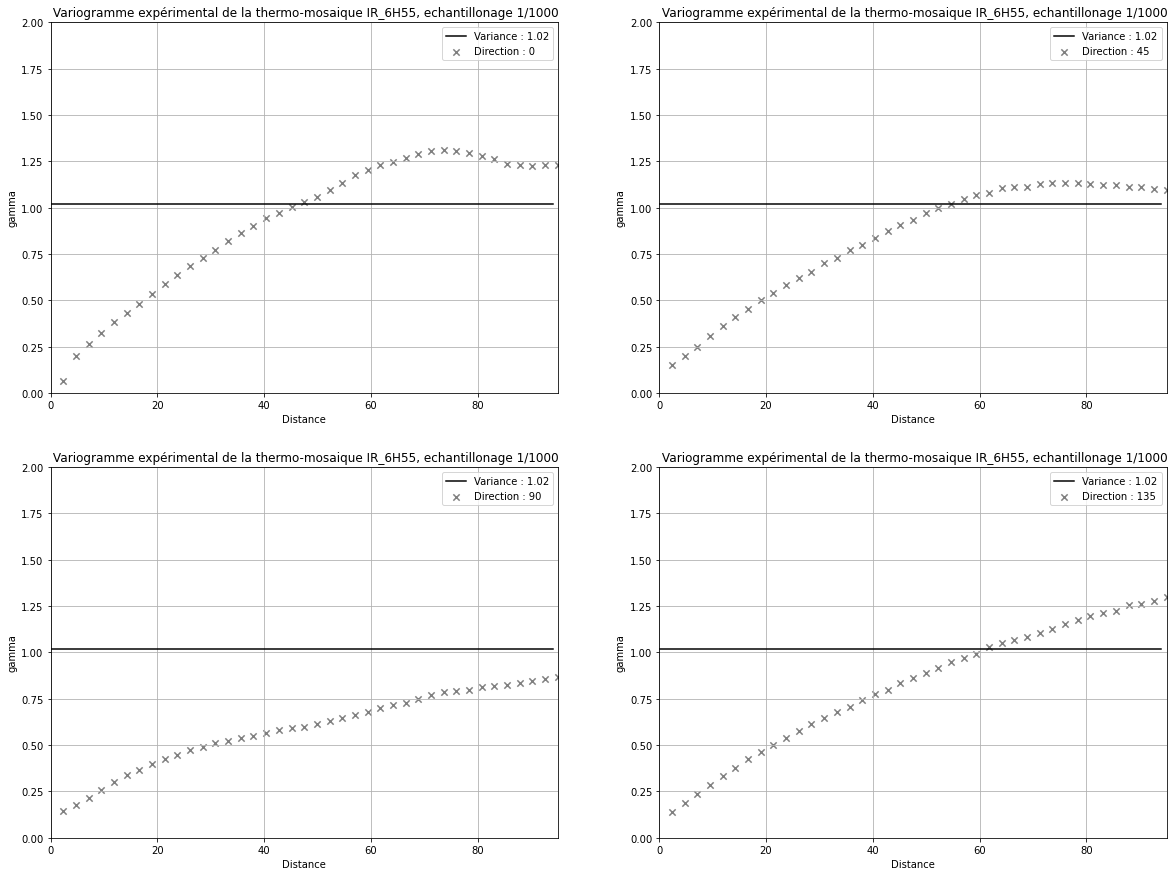

In [192]:
ones = np.ones(shape=(int(L))) * varr_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(varr_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    ax[ii,jj].set_title(" Variogramme expérimental de la thermo-mosaique "+str(requested_IR)+", echantillonage " + str(echantillonage) )
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

## Save

In [296]:
for direction in dist :
    if direction == 45 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 135 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2 = pd.DataFrame()
varc_2["Lag Distance"] = dist_array
varc_2["Number of Pairs"] = count_array
varc_2["Variogram Value"] = gam_array
varc_2["Variogram Index"] = index_array 

In [297]:
varc_2

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,2.375,7934.0,0.152326,1.0
1,4.750,23135.0,0.201084,1.0
2,7.125,38448.0,0.249080,1.0
3,9.500,51700.0,0.310359,1.0
4,11.875,65821.0,0.360253,1.0
...,...,...,...,...
75,85.500,263482.0,1.226205,2.0
76,87.875,262789.0,1.253657,2.0
77,90.250,259823.0,1.263180,2.0
78,92.625,260399.0,1.276504,2.0


In [298]:
low_secondary = pd.DataFrame(np.array([X,Y,Z]).T,columns = [["X","Y","Secondary"]])
low_secondary.to_csv('./varr/low_secondary.csv',index=False)
header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
varc_2.to_csv('./varr/varc_2.csv',index=False,header = header)

## Variogram sur l'espace autour des sondes

### Choix d'une IR

In [9]:
dict_IR_convex_space = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
dict_IR_convex_space.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [10]:
condition = False
if condition :
    dict_IR_convex_space["IR_9H28"]["Secondary"].to_csv("9h28_to_surfer.csv")

In [47]:
requested_IR = ["IR_9H28"]

filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_df = reading_gps_file(filename_Sensor_txt)
Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]
ech = 2
for IR in requested_IR :
    Secondary_convex = dict_IR_convex_space[IR]["Secondary"]
    Secondary_convex = Secondary_convex.dropna(axis = 0)
    Secondary_convex = Secondary_convex[::ech]
    Secondary_convex = Secondary_convex.reset_index(drop=True)
    echantillonage_convex = dict_IR_convex_space[IR]["echantillonage"]

In [48]:
X = Secondary_convex["X"].astype(float).values
Y = Secondary_convex["Y"].astype(float).values
Z = Secondary_convex["Secondary"].astype(float).values
f"Nombre de points à considérer : {X.shape[0]}"

'Nombre de points à considérer : 238709'

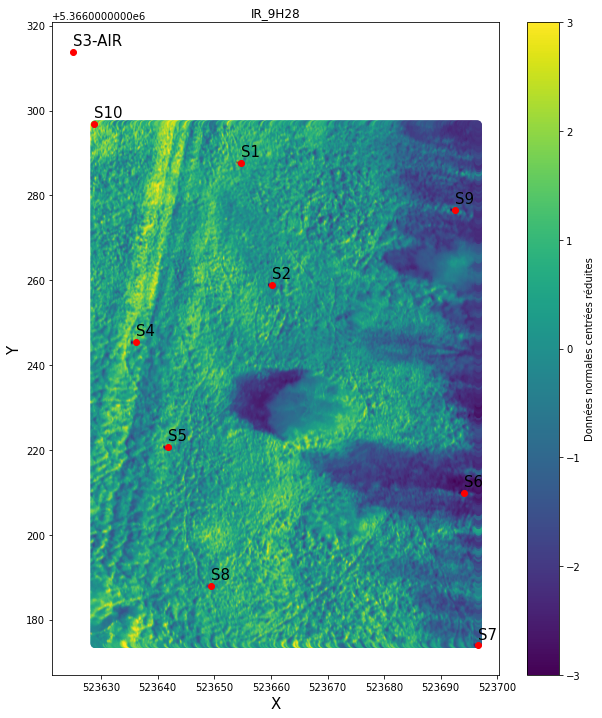

In [18]:
condition = True
if condition :
    # On check les matrices crées, prend du temps à zaper si on s'en fout
    ech = 1
    fig,ax=plt.subplots(1,1, figsize = (10,12))
    img0 = ax.scatter(X[::ech],Y[::ech],c = Z[::ech],vmin = -3, vmax = 3)
    ax.set_xlabel('X', size = 15)
    ax.set_ylabel('Y', size = 15)
    ax.set_title(requested_IR[0])
    #ax.grid()
    fig.colorbar(img0, ax=ax,label = "Données normales centrées réduites")

    Target_x = np.array(Sensor_df["x"],dtype = float)
    Target_y = np.array(Sensor_df["y"],dtype = float)
    Sensor_Name = np.array(Sensor_df["SensorName"],dtype = str)

    plt.plot(Target_x,Target_y,"ro")
    for k in range(len(Target_x)) :
        plt.text(Target_x[k],Target_y[k]+1.5,Sensor_Name[k], size = 15 )


## Paramètrage du Variogram

In [49]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 2.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 523706.655  	 Distance maximale retenue : 58.63000000000466
nlag : 29


## Calcul du Variogram 

In [50]:
direction = [45,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 238709
Iteration 10000 / 238709
Iteration 20000 / 238709
Iteration 30000 / 238709
Iteration 40000 / 238709
Iteration 50000 / 238709
Iteration 60000 / 238709
Iteration 70000 / 238709
Iteration 80000 / 238709
Iteration 90000 / 238709
Iteration 100000 / 238709
Iteration 110000 / 238709
Iteration 120000 / 238709
Iteration 130000 / 238709
Iteration 140000 / 238709
Iteration 150000 / 238709
Iteration 160000 / 238709
Iteration 170000 / 238709
Iteration 180000 / 238709
Iteration 190000 / 238709
Iteration 200000 / 238709
Iteration 210000 / 238709
Iteration 220000 / 238709
Iteration 230000 / 238709
direction done : 45
RUN TIME : 890.0234823999926
Iteration 0 / 238709
Iteration 10000 / 238709
Iteration 20000 / 238709
Iteration 30000 / 238709
Iteration 40000 / 238709
Iteration 50000 / 238709
Iteration 60000 / 238709
Iteration 70000 / 238709
Iteration 80000 / 238709
Iteration 90000 / 238709
Iteration 100000 / 238709
Iteration 110000 / 238709
Iteration 120000 / 238709
Iteration 130000 

## Save

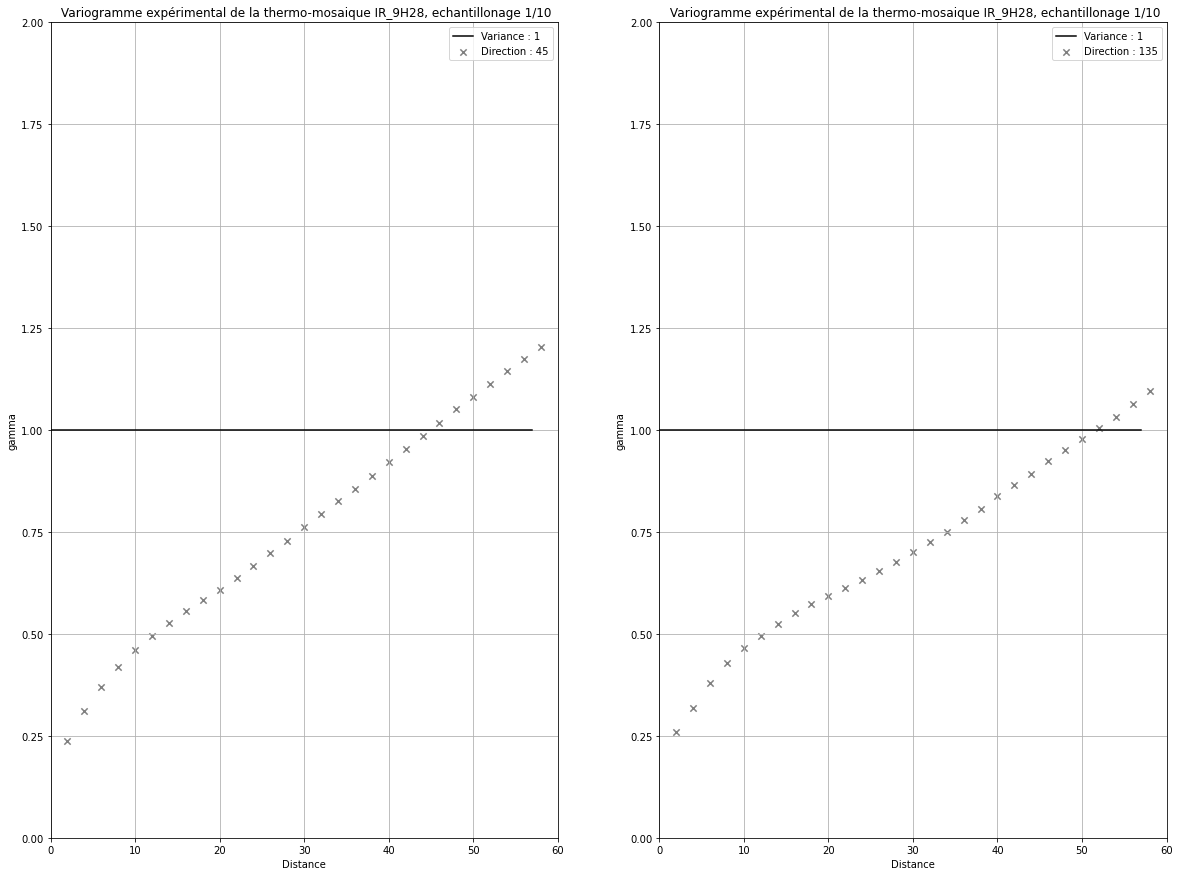

In [51]:
ones = np.ones(shape=(int(L))) * 1
H    = np.arange(0,int(L))
fig,ax=plt.subplots(1,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[jj].plot(H,ones,"black", label = "Variance : " + str(1))
    ax[jj].set_xlabel('Distance')
    ax[jj].set_ylabel('gamma')
    ax[jj].grid()
    ax[jj].legend()
    ax[jj].set_ylim([0,2])
    ax[jj].set_xlim([0,60])
    ax[jj].set_title(" Variogramme expérimental de la thermo-mosaique "+str(requested_IR[0])+", echantillonage 1/" + str(echantillonage_convex) )
    jj +=1

In [52]:
for direction in dist :
    if direction == 45 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 135 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2_convex = pd.DataFrame()
varc_2_convex["Lag Distance"] = dist_array
varc_2_convex["Number of Pairs"] = count_array
varc_2_convex["Variogram Value"] = gam_array
varc_2_convex["Variogram Index"] = index_array 

In [22]:
varc_2_convex

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,1.0,4394965.0,0.267947,1.0
1,2.0,14239973.0,0.362020,1.0
2,3.0,22551592.0,0.415167,1.0
3,4.0,31795502.0,0.459532,1.0
4,5.0,38363470.0,0.504418,1.0
...,...,...,...,...
85,41.0,172441604.0,0.972503,2.0
86,42.0,172879362.0,0.983623,2.0
87,43.0,171729558.0,0.997237,2.0
88,44.0,171920803.0,1.011524,2.0


In [322]:
condition = False
if condition :
    low_secondary.to_csv('./varr/low_secondary.csv',index=False)
    header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
    varc_2_convex.to_csv('./varr/varc_2_convex.csv',index=False,header = header )

In [53]:
Secondary_variogram = {"DataFrame": Secondary_convex ,
                     "Variogram" : varc_2_convex,
                     "enchantillonage" : echantillonage_convex ,
                     "IR_time" :requested_IR[0]}

filename = "./varr/Secondary_variogram/"+str(requested_IR[0])+"_"+str(TEMP)+"_convex.npy"
np.save(filename,Secondary_variogram)

In [54]:
varc_2_convex = pd.DataFrame()
varc_2_convex["Lag Distance"] = dist_array
varc_2_convex["Number of Pairs"] = count_array
varc_2_convex["Variogram Value"] = gam_array
varc_2_convex["Variogram Index"] = index_array 

Secondary_variogram = {"DataFrame": Secondary_convex ,
                 "Variogram" : varc_2_convex,
                 "enchantillonage" : echantillonage_convex ,
                 "IR_time" : requested_IR[0]}

filename = "./varr/Secondary_variogram/Boucle/"+str(requested_IR[0])+"_convex.npy"
np.save(filename,Secondary_variogram)
print("Complited :",IR)

Complited : IR_9H28


## Boucle

In [95]:
dict_IR_convex_space.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [100]:
dict_IR_convex_space = np.load("dict_IR_convex_space.npy",allow_pickle='TRUE').item()
for IR in dict_IR_convex_space :
    Secondary_convex = dict_IR_convex_space[IR]["Secondary"]
    echantillonage_convex = dict_IR_convex_space[IR]["echantillonage"]

    X = Secondary_convex["X"].astype(float).values
    Y = Secondary_convex["Y"].astype(float).values
    Z = Secondary_convex["Secondary"].astype(float).values
    varr_z = 1

    L=(max(X)-min(X))*2/3 # distance maximale
    print("max x :", max(X), " \t Distance maximale retenue :",L)
    w = 1.0 # width, taille des lags
    print("nlag :" , np.int(np.fix(L/w)))

    direction = [0,45,90,135]
    angle_tolerance = 22.5
    dist, counts, gam = {}, {}, {}

    for Dir in direction :
        st1 = timeit.default_timer()
        dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
        print("direction done :", Dir)
        st2 = timeit.default_timer()
        print("RUN TIME : {0}".format(st2-st1))

    for direction in dist :
        if direction == 45 :
            index_major = np.ones((1,len(dist[direction])))
            dist_major  = dist[direction]
            gam_major   = gam[direction]
            count_major = counts[direction]
        elif direction == 135 :
            index_minor = np.ones((1,len(dist[direction]))) * 2
            dist_minor  = dist[direction]
            gam_minor   = gam[direction]
            count_minor = counts[direction]

    index_array = np.append(index_major,index_minor)
    dist_array  = np.append(dist_major,dist_minor)
    gam_array   = np.append(gam_major,gam_minor)
    count_array   = np.append(count_major,count_minor)

    varc_2_convex = pd.DataFrame()
    varc_2_convex["Lag Distance"] = dist_array
    varc_2_convex["Number of Pairs"] = count_array
    varc_2_convex["Variogram Value"] = gam_array
    varc_2_convex["Variogram Index"] = index_array 
    
    Secondary_variogram = {"DataFrame": Secondary_convex ,
                     "Variogram" : varc_2_convex,
                     "enchantillonage" : echantillonage_convex ,
                     "IR_time" : IR}
    
    filename = "./varr/Secondary_variogram/Boucle/"+str(IR)+"_convex.npy"
    np.save(filename,Secondary_variogram)
    print("Complited :",IR)

max x : 523696.655  	 Distance maximale retenue : 45.29666666667132
nlag : 45
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 0
RUN TIME : 14.258189000014681
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 45
RUN TIME : 14.510142499988433
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 90
RUN TIME : 14.203027199982898
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 135
RUN TIME : 14.680984700011322
Complited : IR_6H55
max x : 523696.655  	 Distance maximale retenue : 45.29666666667132
nlag : 45
Iteration 0 / 33183
Iteration 10000 / 33183
Iteration 20000 / 33183
Iteration 30000 / 33183
direction done : 0
RUN TIME : 17.647905599995283
Iteration 0 / 33183
Iteration 10000 / 33183
Iteration 20000 / 33183
Iteration 30000 / 33183
direction done : 45
RUN TIME : 17.965282999997726
Iteration 0 / 33183
Iteration 10000 / 33183
Iteration 20000 / 33183
I

# Importation des données de Température (Z)

### Importation de l'heure de vole du drone (Requested_IR)

In [22]:
dict_IR_convex_space.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [9]:
requested_IR = ["IR_9H28"]
TEMP = 'T4'

In [10]:
print("IR sélectionnée :",requested_IR[0])
print("sensor sélectionné :",TEMP)

IR sélectionnée : IR_9H28
sensor sélectionné : T4


In [11]:
# Contient les pseudo_temp modifié en fonction du numéro de cluster
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
IR_time = dict_PT_all_temp[requested_IR[0]]['IR_time']
dict_PT_all_temp.keys()

dict_IR_Df = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
Secondary = dict_IR_Df[requested_IR[0]]["Secondary"]

### Ajout de la fenêtre de temps à un DataFrame & des Températures à +/- 15 min

In [55]:
concatenate_s3 = np.empty(0)
date_1='2019-04-14 06:00:00'
date_2='2019-04-14 18:30:00'
dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"


for requested_IR in dict_IR_Df :
    IR_time_equal = dict_PT_all_temp[requested_IR]['IR_time']
    IR_time_list = [IR_time_equal]
    # DF 
    for IR_time in IR_time_list :
        print(IR_time)
        Primary = reading_gps_file(filename_Sensor_txt)
        Primary[TEMP] = 0
        for sensor in dict_temp_sensor :
            value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
            Primary[TEMP].loc[Primary["SensorName"] == sensor] = value.values
        concatenate_s3 = np.append(concatenate_s3,Primary.loc[Primary["SensorName"] == "S3-AIR"]["T4"].values)
            
filename = "./varr/Estimate/S3_AIR_data.npy"
np.save(filename,concatenate_
        s3)

2019-04-14 07:00:00
2019-04-14 07:30:00
2019-04-14 08:30:00
2019-04-14 09:30:00
2019-04-14 10:30:00
2019-04-14 11:30:00
2019-04-14 12:30:00
2019-04-14 13:30:00
2019-04-14 16:00:00
2019-04-14 17:30:00


In [39]:
Primary.loc[Primary["SensorName"] == "S3-AIR"]["T4"].values

array([-5.522])

In [12]:
Primary_to_concatenate = np.empty(0)
date_1='2019-04-14 06:00:00'
date_2='2019-04-14 18:30:00'
dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
IR_time_plus  = dict_PT_all_temp[requested_IR[0]]['IR_time'] + pd.Timedelta("15min")
IR_time_equal = dict_PT_all_temp[requested_IR[0]]['IR_time']
IR_time_minus = dict_PT_all_temp[requested_IR[0]]['IR_time'] - pd.Timedelta("15min")
IR_time_list = [IR_time_equal]
# DF 
for IR_time in IR_time_list :
    print(IR_time)
    Primary = reading_gps_file(filename_Sensor_txt)
    Primary[TEMP] = 0
    for sensor in dict_temp_sensor :
        value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
        Primary[TEMP].loc[Primary["SensorName"] == sensor] = value.values

    Primary = Primary.loc[Primary["SensorName"] != "S3-AIR"]
    Primary["IR_time"] = IR_time
    Primary_array = Primary.values
    Primary_to_concatenate = np.append(Primary_to_concatenate,Primary_array)
Primary = pd.DataFrame(Primary_to_concatenate.reshape(Primary.shape[0]*len(IR_time_list),Primary.shape[1]))  
Primary.columns = ["SensorName","x","y",TEMP,"IR_time"]
Primary["Primary"] = (Primary[TEMP]- Primary[TEMP].mean()) / Primary[TEMP].std() # Normal score

2019-04-14 09:30:00


C:\Users\Alexandre\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
Primary

,SensorName,x,y,T4,IR_time,Primary
0,S10,523628.71,5366296.81,6.209,2019-04-14 09:30:00,1.560044
1,S1,523654.74,5366287.75,4.741,2019-04-14 09:30:00,0.19125
2,S9,523692.47,5366276.57,3.53,2019-04-14 09:30:00,-0.937912
3,S2,523660.22,5366258.91,4.736,2019-04-14 09:30:00,0.186588
4,S4,523636.075,5366245.545,6.097,2019-04-14 09:30:00,1.455612
5,S5,523641.825,5366220.67,4.27,2019-04-14 09:30:00,-0.24792
6,S8,523649.33,5366188.02,4.446,2019-04-14 09:30:00,-0.083814
7,S7,523696.655,5366174.0,3.712,2019-04-14 09:30:00,-0.768211
8,S6,523694.05,5366209.93,3.082,2019-04-14 09:30:00,-1.355636


In [149]:
Primary.to_csv("./Ck_surfer/extensed_Primary.csv")

### Densification de la zone de point autour des sondes pour un rayon défini

In [20]:
def Primary_densification(Primary, Secondary, radius,ech = 100) :
    # On récupère la zone autour d'une sonde
    x0_array = Primary[Primary.keys()[1]].astype(float).values
    y0_array = Primary[Primary.keys()[2]].astype(float).values
    z0_array = Primary[Primary.keys()[-1]].astype(str).values # Conversion en str pour mulptiplication des valeurs
    sensor_name_array = Primary[Primary.keys()[0]].astype(str).values # Conversion en str pour mulptiplication des valeurs
    
    ## Initialisation des constantes / matrices
    x_array = np.empty(0)
    y_array = np.empty(0)
    z_array = np.empty(0)
    s_array = np.empty(0) # sensor name array
    
    for x0,y0,z0,s0 in zip(x0_array,y0_array,z0_array,sensor_name_array) :
        #print("x0 :",x0," y0 :",y0," z0 :",z0)
        # Réduction du rayon de recherche au préalable
        exp = "(X > " + str(x0-radius) + " & " + "X < " + str(x0+radius) + ") & "
        exp = "(Y > " + str(y0-radius) + " & " + "Y < " + str(y0+radius) +")"
        Mask_area_df = Secondary.query(exp)
        
        # Distance
        Mask_area_df['r'] = np.sqrt((x0-Mask_area_df["X"])**2 + (y0-Mask_area_df["Y"])**2)
        # Condition à respecter
        Intermediate_df = Mask_area_df.query("r < " + str(radius))
        
        x_array = np.append(x_array,[x0, *Intermediate_df["X"].values[0:10]])
        y_array = np.append(y_array,[y0, *Intermediate_df["Y"].values[0:10]])
        length = len(Intermediate_df["X"].values[0:10]) + 1
        z_array = np.append(z_array,[z0]*length)
        s_array = np.append(s_array,[s0]*length)
        #print("x.shape :",x_array.shape," y.shape :",y_array.shape," z.shape :",z_array.shape)
    Primary = pd.DataFrame()
    Primary["SensorName"] = s_array
    Primary["x"] = x_array
    Primary["y"] = y_array
    Primary["Primary"] = z_array.astype(float)

    return Primary

In [30]:
Primary_dense = Primary_densification(Primary, Secondary_convex, 2)

<ipython-input-28-1525f75e9789>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mask_area_df['r'] = np.sqrt((x0-Mask_area_df["X"])**2 + (y0-Mask_area_df["Y"])**2)


###  Statistique et mise en place du variogram

In [35]:
varr = Primary["Primary"].var()
varr = float("{:.2f}".format(varr))
print("Variance :",varr)

Variance : 1.0


In [36]:
# On utilise les valeurs transformées
X = Primary["x"].astype(float).values
Y = Primary["y"].astype(float).values
Z = Primary["Primary"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 9
Y : 9
Z : 9


#### Affichage des données de sondes

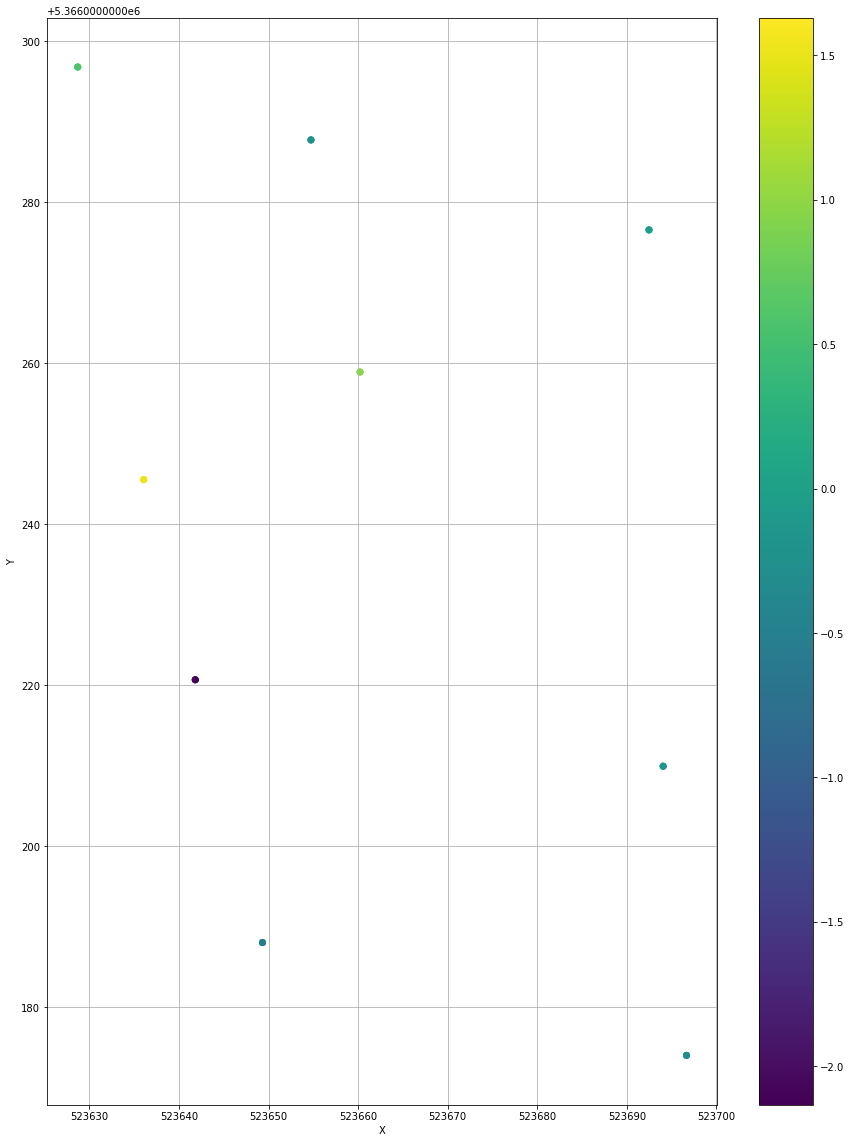

In [126]:
Condition = True
if Condition :
    # On check les matrices crées, prend du temps à zaper si on s'en fout
    fig,ax=plt.subplots(1,1, figsize = (15,20))
    img0 = ax.scatter(X,Y,c = Z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    fig.colorbar(img0, ax=ax)

### Estimation de la distance maximale entre les sondes

In [127]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 140.35248171977688


## Paramètrage du variogram

In [150]:
L = distance_variable * 2/3
print("Distance maximale retenue :",L)
#w = 15.0 # width, taille des lags
w = 4
print("nlag :" , np.int(np.fix(L/w)))

Distance maximale retenue : 93.56832114651792
nlag : 23


### Calcul du variogram

In [146]:
direction = [0]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 27
direction done : 0
RUN TIME : 0.0005341000005500973


In [147]:
print("Valeurs du semi-variogramme :",gam[0])
print("Nombres de pairs :",counts[0])

Valeurs du semi-variogramme : [1.14071501e-03            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
 6.84032872e+00 3.01168662e-01 7.19718685e-01            nan
 1.28293402e+00            nan 3.06400495e-01 1.67677009e-02
            nan 4.73612756e+00            nan 1.70692028e+00
 4.95012250e-02 4.32385513e-01 1.89027048e+00            nan
            nan 1.44105487e+00            nan            nan
 1.35299006e+00 1.09225603e-01 1.58140196e+00 1.05014243e+00
 1.67276504e+00 2.10877747e+00 3.72336686e+00            nan
            nan            nan            nan 1.37077242e-03
            nan            nan]
Nombres de pairs : [54.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  9.  6.  0.  6.  0.
  6.  6.  0.  3.  0.  3. 18.  6.  6.  0.  0. 12.  0.  0.  3. 12.  9.  3.
  6.  3.  6.  0.  0.  0.  0.  6.  0.  0.]


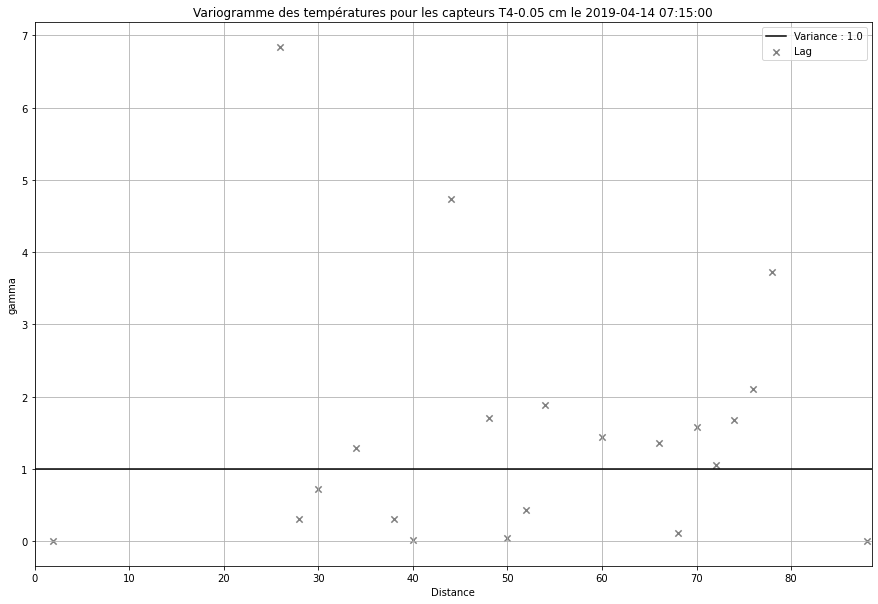

In [148]:
ones = np.ones(shape=(100)) * varr
H    = np.arange(0,100)
fig,ax=plt.subplots(1,1,figsize = (15,10))
LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
sensor = str(LABEL[int(TEMP[-1])-1])
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,88.5])


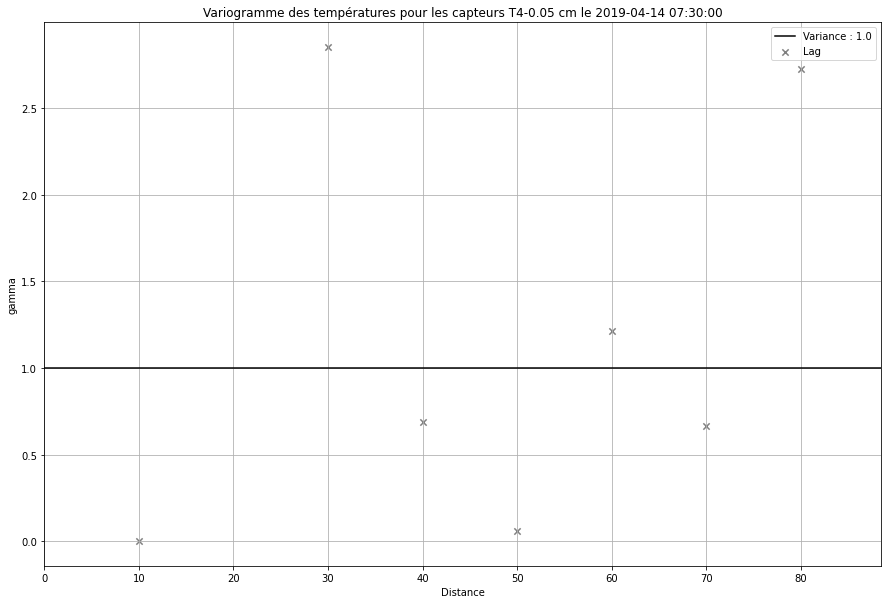

In [26]:
ones = np.ones(shape=(100)) * varr
H    = np.arange(0,100)
fig,ax=plt.subplots(1,1,figsize = (15,10))
LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
sensor = str(LABEL[int(TEMP[-1])-1])
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,88.5])


## Sauvegarde

In [27]:
distonce = [1,2]

In [28]:
for direction in distonce :
    if direction == 1 :
        index_major = np.ones((1,len(dist[0])))
        dist_major  = dist[0]
        gam_major   = gam[0]
        count_major = counts[0]
    elif direction == 2 :
        index_minor = np.ones((1,len(dist[0]))) * 2
        dist_minor  = dist[0]
        gam_minor   = gam[0]
        count_minor = counts[0]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_1 = pd.DataFrame()
varc_1["Lag Distance"] = dist_array
varc_1["Number of Pairs"] = count_array
varc_1["Variogram Value"] = gam_array
varc_1["Variogram Index"] = index_array 

### Sauvegarde d'un package

In [29]:
Primary_variogram = {"DataFrame": Primary ,
                     "DataFrame_dense" : Primary_dense,
                     "Variogram" : varc_1,
                     "sensor" : TEMP,
                     "IR_time" :requested_IR[0]}

In [30]:
filename = "./varr/Primary_variogram/Boucle/"+str(requested_IR[0])+"_"+str(TEMP)+".npy"
np.save(filename,Primary_variogram)

## Boucle

In [14]:
dict_PT_all_temp

{'IR_6H55': {'T1': [10.53,
   11.018,
   9.643,
   10.883,
   9.929,
   9.416,
   10.603,
   10.211,
   10.387],
  'T2': [10.449, 11.012, 9.577, 10.707, 9.792, 9.423, 10.563, 11.61, 10.38],
  'T3': [9.595, 10.368, 8.971, 10.078, 8.556, 8.874, 9.898, 9.481, 9.846],
  'T4': [2.552, 3.543, 4.046, 4.704, 0.228, 2.633, 2.496, 2.232, 2.815],
  'IR_time': Timestamp('2019-04-14 07:00:00'),
  'IR_temp_value': [-2.397539068983635,
   -1.436520570341762,
   -2.55904933180569,
   -0.44974210376401025,
   -1.05655847824503,
   -1.6839822347640565,
   -0.5063835227451885,
   -1.2992396968240434,
   -1.056512213007008],
  'Sensor_list': {'S1': -2.397539068983635,
   'S10': -1.436520570341762,
   'S2': -2.55904933180569,
   'S4': -0.44974210376401025,
   'S5': -1.05655847824503,
   'S6': -1.6839822347640565,
   'S7': -0.5063835227451885,
   'S8': -1.2992396968240434,
   'S9': -1.056512213007008}},
 'IR_7H29': {'T1': [10.527,
   11.017,
   9.641,
   10.879,
   9.926,
   9.415,
   10.602,
   10.202,
   

In [23]:
dict_PT_all_temp.keys()
for TEMP in ["T1","T2","T3","T4"] :
    print(TEMP)

T1
T2
T3
T4


In [24]:
IR_time

Timestamp('2019-04-14 17:30:00')

In [21]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
dict_IR_Df = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
for requested_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        IR_time = dict_PT_all_temp[requested_IR]['IR_time']
        
        # Fenêtre des données issus de la sonde au format DataFrame
        date_1='2019-04-14 06:00:00'
        date_2='2019-04-14 18:30:00'
        dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
        filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
        Primary_c = reading_gps_file(filename_Sensor_txt)
        Primary_c[TEMP] = 0
        for sensor in dict_temp_sensor :
            value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
            Primary_c[TEMP].loc[Primary_c["SensorName"] == sensor] = value.values

        Primary = Primary_c.loc[Primary_c["SensorName"] != "S3-AIR"] 
        Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score
        
        
        # Densification des données de sonde
        Secondary = dict_IR_Df[requested_IR]["Secondary"]
        Primary_dense = Primary_densification(Primary, Secondary, 2)
        
        X = Primary_dense["x"].astype(float).values
        Y = Primary_dense["y"].astype(float).values
        Z = Primary_dense["Primary"].astype(float).values
        
        ## Distance maximale à retenir
        distance_variable = 0
        for i in range(0,len(X)) :
            for j in range (0,len(X)) :
                x = X[i] - X[j]
                y = Y[i] - Y[j]
                dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
                if dist_temp > distance_variable :
                    distance_variable = dist_temp
        
        ## Calcul & paramètrage du variogram
        L = distance_variable * 2/3
        w =15
        direction = [0]
        angle_tolerance = 90
        dist, counts, gam = {}, {}, {}

        for Dir in direction :
            st1 = timeit.default_timer()
            dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
            st2 = timeit.default_timer()
            print("RUN TIME : {0}".format(st2-st1))
        
        ## Save
        for direction in [1,2] :
            if direction == 1 :
                index_major = np.ones((1,len(dist[0])))
                dist_major  = dist[0]
                gam_major   = gam[0]
                count_major = counts[0]
            elif direction == 2 :
                index_minor = np.ones((1,len(dist[0]))) * 2
                dist_minor  = dist[0]
                gam_minor   = gam[0]
                count_minor = counts[0]

        index_array = np.append(index_major,index_minor)
        dist_array  = np.append(dist_major,dist_minor)
        gam_array   = np.append(gam_major,gam_minor)
        count_array   = np.append(count_major,count_minor)

        varc_1 = pd.DataFrame()
        varc_1["Lag Distance"] = dist_array
        varc_1["Number of Pairs"] = count_array
        varc_1["Variogram Value"] = gam_array
        varc_1["Variogram Index"] = index_array 
            
        Primary_variogram = {"DataFrame": Primary ,
                     "Variogram" : varc_1,
                     "DataFrame_dense" : Primary_dense,
                     "sensor" : TEMP,
                     "IR_time" :requested_IR}
        
        filename = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
        np.save(filename,Primary_variogram)
    print("Complited :",requested_IR)
        

<ipython-input-21-7545663bc462>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score
<ipython-input-20-1525f75e9789>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mask_area_df['r'] = np.sqrt((x0-Mask_area_df["X"])**2 + (y0-Mask_area_df["Y"])**2)


Iteration 0 / 99
RUN TIME : 0.43853600008878857
Iteration 0 / 99
RUN TIME : 0.0005604000762104988
Iteration 0 / 99
RUN TIME : 0.0003942999755963683
Iteration 0 / 99
RUN TIME : 0.0006510999519377947
Complited : IR_6H55
Iteration 0 / 99
RUN TIME : 0.00038079998921602964
Iteration 0 / 99
RUN TIME : 0.00037679995875805616
Iteration 0 / 99
RUN TIME : 0.0003782999701797962
Iteration 0 / 99
RUN TIME : 0.000372599926777184
Complited : IR_7H29
Iteration 0 / 99
RUN TIME : 0.00042100006248801947
Iteration 0 / 99
RUN TIME : 0.0003696000203490257
Iteration 0 / 99
RUN TIME : 0.0011600999860092998
Iteration 0 / 99
RUN TIME : 0.000737300026230514
Complited : IR_8H22
Iteration 0 / 99
RUN TIME : 0.0003966999938711524
Iteration 0 / 99
RUN TIME : 0.0010779999429360032
Iteration 0 / 99
RUN TIME : 0.000381799996830523
Iteration 0 / 99
RUN TIME : 0.0004561000969260931
Complited : IR_9H28
Iteration 0 / 99
RUN TIME : 0.0003804001025855541
Iteration 0 / 99
RUN TIME : 0.0011476000072434545
Iteration 0 / 99
RUN T

# Cross Variogram

In [46]:
Primary.keys()

Index(['SensorName', 'x', 'y', 'T4', 'Primary'], dtype='object')

In [26]:
def Primary_Cross_densification(Primary, Secondary, radius,ech = 100) :
    # On récupère la zone autour d'une sonde
    x0_array = Primary[Primary.keys()[1]].astype(float).values
    y0_array = Primary[Primary.keys()[2]].astype(float).values
    z0_array = Primary["Primary"].astype(str).values # Conversion en str pour mulptiplication des valeurs
    zy0_array = Primary["Secondary"].astype(str).values # Conversion en str pour mulptiplication des valeurs
    sensor_name_array = Primary["SensorName"].astype(str).values # Conversion en str pour mulptiplication des valeurs
    
    ## Initialisation des constantes / matrices
    x_array = np.empty(0)
    y_array = np.empty(0)
    z_array = np.empty(0) # primary name array
    zy_array = np.empty(0) # secondary name array 
    s_array = np.empty(0) # sensor name array
    
    for x0,y0,z0,zy0,s0 in zip(x0_array,y0_array,z0_array,zy0_array,sensor_name_array) :
        #print("x0 :",x0," y0 :",y0," z0 :",z0)
        # Réduction du rayon de recherche au préalable
        exp = "(X > " + str(x0-radius) + " & " + "X < " + str(x0+radius) + ") & "
        exp = "(Y > " + str(y0-radius) + " & " + "Y < " + str(y0+radius) +")"
        Mask_area_df = Secondary.query(exp)
        
        # Distance
        Mask_area_df['r'] = np.sqrt((x0-Mask_area_df["X"])**2 + (y0-Mask_area_df["Y"])**2)
        # Condition à respecter
        Intermediate_df = Mask_area_df.query("r < " + str(radius))
        
        x_array = np.append(x_array,[x0, *Intermediate_df["X"].values[0:10]])
        y_array = np.append(y_array,[y0, *Intermediate_df["Y"].values[0:10]])
        length = len(Intermediate_df["X"].values[0:10]) + 1
        z_array = np.append(z_array,[z0]*length)
        zy_array = np.append(zy_array,[zy0]*length)
        s_array = np.append(s_array,[s0]*length)
        #print("x.shape :",x_array.shape," y.shape :",y_array.shape," z.shape :",z_array.shape)
    Primary = pd.DataFrame()
    Primary["SensorName"] = s_array
    Primary["x"] = x_array
    Primary["y"] = y_array
    Primary["Primary"] = z_array.astype(float)
    Primary["Secondary"] = zy_array.astype(float)

    return Primary

In [48]:
print("IR sélectionnée :",requested_IR[0])
print("sensor sélectionné :",TEMP)

IR sélectionnée : IR_6H55
sensor sélectionné : T4


###  Importation de l'heure de vol du drone et des données de sonde

In [49]:
Condition = True
if Condition :
    dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
    IR_time = dict_PT_all_temp[requested_IR[0]]['IR_time']
    TEMP = 'T4'
    Pseudo_temperature = dict_PT_all_temp[requested_IR[0]]['IR_temp_value']
    Sensor_list = dict_PT_all_temp[requested_IR[0]]['Sensor_list']
    dict_PT_all_temp[requested_IR[0]].keys()

In [52]:
file_requested = "./varr/Primary_variogram/Boucle/"+str(requested_IR[0])+"_"+str(TEMP)+".npy"
Primary_variogram = np.load(file_requested,allow_pickle='TRUE').item()

### Ajout des valeurs de drone situées coordonnées des sondes (Pseudo-Temp)

In [53]:
# Pseudo Température
df_PT = pd.DataFrame()
df_PT["Sensor_list"] = Sensor_list
df_PT["Pseudo_temp"] = Pseudo_temperature

In [54]:
Primary_variogram.keys()

dict_keys(['DataFrame', 'DataFrame_dense', 'Variogram', 'sensor', 'IR_time'])

In [55]:
list_value = []
for sensor in Primary["SensorName"] :
    list_value.append(df_PT["Pseudo_temp"].loc[df_PT["Sensor_list"] == sensor].mean())
copy_df = Primary.copy()
copy_df["Pseudo_temp"] = list_value
# Normal score
Primary['Pseudo_temp'] = list_value
Primary["Secondary"] = (copy_df["Pseudo_temp"]- np.mean(copy_df["Pseudo_temp"].values)) / np.sqrt(np.var(copy_df["Pseudo_temp"].values))

### Densification de la zone de point autour des sondes pour un rayon défini

In [56]:
Primary_dense = Primary_Cross_densification(Primary, Secondary, 2)

<ipython-input-47-63f93decaca8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mask_area_df['r'] = np.sqrt((x0-Mask_area_df["X"])**2 + (y0-Mask_area_df["Y"])**2)


In [60]:
X = Primary_dense["x"].astype(float).values
Y = Primary_dense["y"].astype(float).values
Z = Primary_dense["Secondary"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 99
Y : 99
Z : 99


### Estiamtion de la distance maximale à retenir

In [61]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 141.8966206654036


###  Paramètrage et calcul du variogram

In [62]:
L = distance_variable * 2/3
print("Distance maximale retenue :",L)
w =10 # Taille des lags
print("nlag :" , np.int(np.fix(L/w)))

Distance maximale retenue : 94.59774711026905
nlag : 9


In [63]:
direction = [0]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))
    varr = 1

Iteration 0 / 99
direction done : 0
RUN TIME : 0.0009479999998802668


In [64]:
print("Valeurs du semi-variogramme :",gam[0])
print("Nombres de pairs :",counts[0])

Valeurs du semi-variogramme : [0.                nan 0.46489666 0.88175648 0.77989493 0.70378365
 0.72203676 0.23042213 0.52485814]
Nombres de pairs : [504.   0. 353. 242. 303. 519. 388. 242. 121.]


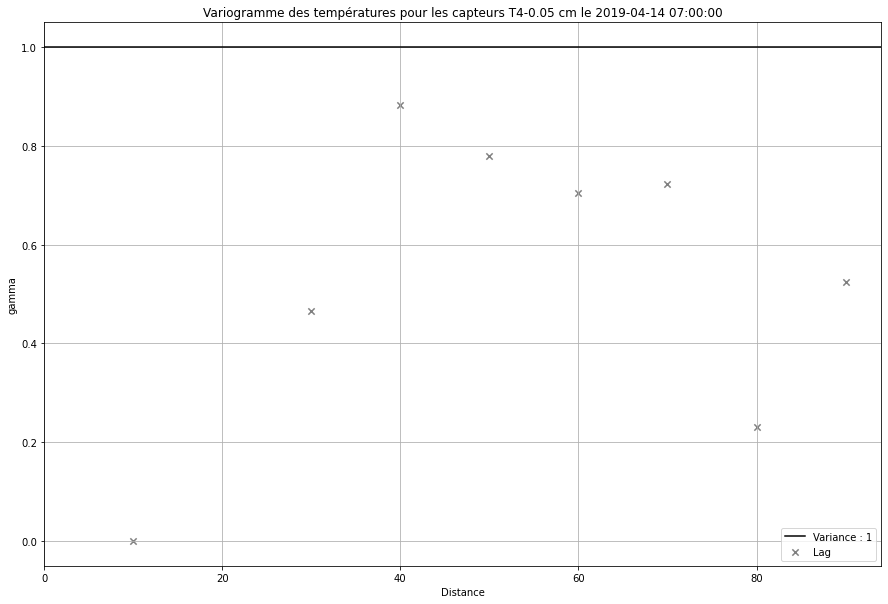

In [65]:
ones = np.ones(shape=(100)) * varr
H    = np.arange(0,100)
fig,ax=plt.subplots(1,1,figsize = (15,10))
LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
sensor = str(LABEL[int(TEMP[-1])-1])
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,int(L)])


## Save

In [66]:
for direction in [1,2] :
    if direction == 1 :
        index_major = np.ones((1,len(dist[0])))
        dist_major  = dist[0]
        gam_major   = gam[0]
        count_major = counts[0]
    elif direction == 2 :
        index_minor = np.ones((1,len(dist[0]))) * 2
        dist_minor  = dist[0]
        gam_minor   = gam[0]
        count_minor = counts[0]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_3 = pd.DataFrame()
varc_3["Lag Distance"] = dist_array
varc_3["Number of Pairs"] = count_array
varc_3["Variogram Value"] = gam_array
varc_3["Variogram Index"] = index_array 

In [67]:
varc_3

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,10,504.0,0.000000,1.0
1,20,0.0,NaN,1.0
2,30,353.0,0.464897,1.0
3,40,242.0,0.881756,1.0
4,50,303.0,0.779895,1.0
5,60,519.0,0.703784,1.0
6,70,388.0,0.722037,1.0
7,80,242.0,0.230422,1.0
8,90,121.0,0.524858,1.0
9,10,504.0,0.000000,2.0


In [32]:
condition = False
if condition :
    header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
    varc_3.to_csv('./varr/varc_3.csv',index=False, header = header)
    Primary.to_csv('./varr/Primary_2.csv',index=False)

In [68]:
Cross_variogram = {"DataFrame": Primary ,
                   "DataFrame_dense": Primary_dense,
                    "Variogram" : varc_3,
                    "sensor" : TEMP,
                     "IR_time" :requested_IR[0]}

In [69]:
filename = "./varr/Cross_variogram/Boucle/"+str(requested_IR[0])+"_"+str(TEMP)+".npy"
np.save(filename,Cross_variogram)

## Boucle

In [17]:
Primary

,SensorName,x,y,T4,IR_time,Primary
0,S10,523628.71,5366296.81,6.209,2019-04-14 09:30:00,1.560044
1,S1,523654.74,5366287.75,4.741,2019-04-14 09:30:00,0.19125
2,S9,523692.47,5366276.57,3.53,2019-04-14 09:30:00,-0.937912
3,S2,523660.22,5366258.91,4.736,2019-04-14 09:30:00,0.186588
4,S4,523636.075,5366245.545,6.097,2019-04-14 09:30:00,1.455612
5,S5,523641.825,5366220.67,4.27,2019-04-14 09:30:00,-0.24792
6,S8,523649.33,5366188.02,4.446,2019-04-14 09:30:00,-0.083814
7,S7,523696.655,5366174.0,3.712,2019-04-14 09:30:00,-0.768211
8,S6,523694.05,5366209.93,3.082,2019-04-14 09:30:00,-1.355636


In [153]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
dict_IR_Df = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
for requested_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        IR_time = dict_PT_all_temp[requested_IR]['IR_time']
        Pseudo_temperature = dict_PT_all_temp[requested_IR]['IR_temp_value']
        Sensor_list = dict_PT_all_temp[requested_IR]['Sensor_list']
        file_requested = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
        Primary_variogram = np.load(file_requested,allow_pickle='TRUE').item()
        Primary = Primary_variogram["DataFrame"]
        
        # Pseudo Température
        df_PT = pd.DataFrame()
        df_PT["Sensor_list"] = Sensor_list
        df_PT["Pseudo_temp"] = Pseudo_temperature
        list_value = []
        for sensor in Primary["SensorName"] :
            list_value.append(df_PT["Pseudo_temp"].loc[df_PT["Sensor_list"] == sensor].mean())
        Primary['Pseudo_temp'] = list_value
        # Normal score
        Primary["Secondary"] = (Primary["Pseudo_temp"]- np.mean(Primary["Pseudo_temp"].values)) / np.sqrt(np.var(Primary["Pseudo_temp"].values))
        
        # Densification des points autour de la sonde
        Secondary = dict_IR_Df[requested_IR]["Secondary"]
        Primary_dense = Primary_Cross_densification(Primary, Secondary, 2)
        
        X = Primary_dense["x"].astype(float).values
        Y = Primary_dense["y"].astype(float).values
        Z = Primary_dense["Secondary"].astype(float).values
        
        ## Distance à retenir
        distance_variable = 0
        for i in range(0,len(X)) :
            for j in range (0,len(X)) :
                x = X[i] - X[j]
                y = Y[i] - Y[j]
                dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
                if dist_temp > distance_variable :
                    distance_variable = dist_temp
        
        ## Calcul du variogram
        L = distance_variable * 2/3
        w =15
        direction = [0]
        angle_tolerance = 90
        dist, counts, gam = {}, {}, {}

        for Dir in direction :
            st1 = timeit.default_timer()
            dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
            st2 = timeit.default_timer()
            #print("RUN TIME : {0}".format(st2-st1))
            #print("Variogram Value :", gam[Dir])
            #print("Z :", gam[Dir],"\n")
        
        ## Save
        for direction in [1,2] :
            if direction == 1 :
                index_major = np.ones((1,len(dist[0])))
                dist_major  = dist[0]
                gam_major   = gam[0]
                count_major = counts[0]
            elif direction == 2 :
                index_minor = np.ones((1,len(dist[0]))) * 2
                dist_minor  = dist[0]
                gam_minor   = gam[0]
                count_minor = counts[0]

        index_array = np.append(index_major,index_minor)
        dist_array  = np.append(dist_major,dist_minor)
        gam_array   = np.append(gam_major,gam_minor)
        count_array   = np.append(count_major,count_minor)

        varc_3 = pd.DataFrame()
        varc_3["Lag Distance"] = dist_array
        varc_3["Number of Pairs"] = count_array
        varc_3["Variogram Value"] = gam_array
        varc_3["Variogram Index"] = index_array 
            
        Cross_variogram = {"DataFrame": Primary ,
                           "DataFrame_dense" : Primary_dense,
                     "Variogram" : varc_3,
                     "sensor" : TEMP,
                     "IR_time" :IR_time}
        
        filename = "./varr/Cross_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
        np.save(filename,Cross_variogram)
    print("Complited :",requested_IR)
        

<ipython-input-36-63f93decaca8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mask_area_df['r'] = np.sqrt((x0-Mask_area_df["X"])**2 + (y0-Mask_area_df["Y"])**2)


Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_6H55
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_7H29
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_8H22
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_9H28
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_10H22
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_11H27
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_12H31
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_13H26
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_15H59
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Iteration 0 / 99
Complited : IR_17H27


In [67]:
dict_PT_all_temp.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [84]:
Requested_IR = "IR_8H22"
TEMP = "T4"
filename = "./varr/Cross_variogram/Boucle/"+str(Requested_IR)+"_"+str(TEMP)+".npy"
np.load(filename,allow_pickle='TRUE').item()['Variogram']

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,15,9.0,0.000000,1.0
1,30,3.0,0.414727,1.0
2,45,2.0,0.002221,1.0
3,60,7.0,1.345532,1.0
4,75,4.0,1.890331,1.0
5,90,2.0,0.147939,1.0
6,15,9.0,0.000000,2.0
7,30,3.0,0.414727,2.0
8,45,2.0,0.002221,2.0
9,60,7.0,1.345532,2.0


In [85]:
Requested_IR = "IR_12H31"
TEMP = "T4"
filename = "./varr/Cross_variogram/Boucle/"+str(Requested_IR)+"_"+str(TEMP)+".npy"
np.load(filename,allow_pickle='TRUE').item()['Variogram']

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,15,9.0,0.000000,1.0
1,30,3.0,2.314664,1.0
2,45,2.0,0.044983,1.0
3,60,7.0,0.709159,1.0
4,75,4.0,0.889457,1.0
5,90,2.0,2.122783,1.0
6,15,9.0,0.000000,2.0
7,30,3.0,2.314664,2.0
8,45,2.0,0.044983,2.0
9,60,7.0,0.709159,2.0


,SensorName,x,y,T4,Primary,Pseudo_temp,Secondary
0,S10,523628.71,5366296.81,13.305,-0.156627,14.147304,1.088165
1,S1,523654.74,5366287.75,13.249,-0.186965,14.160220,1.120325
2,S9,523692.47,5366276.57,16.537,1.594320,13.822776,0.280085
3,S2,523660.22,5366258.91,11.116,-1.342525,13.987761,0.690901
4,S4,523636.075,5366245.545,12.736,-0.464885,13.486543,-0.557139
5,S5,523641.825,5366220.67,15.361,0.957218,13.100141,-1.519287
6,S8,523649.33,5366188.02,12.142,-0.786686,13.386816,-0.805461
7,S7,523696.655,5366174.0,16.123,1.370034,14.116577,1.011656
8,S6,523694.05,5366209.93,11.778,-0.983884,13.184495,-1.309246


In [90]:
dict_PT_all_temp[REQUESTED_IR]['IR_time']

Timestamp('2019-04-14 17:30:00')

<ipython-input-93-a4c4f19df92a>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1,figsize = (15,10))


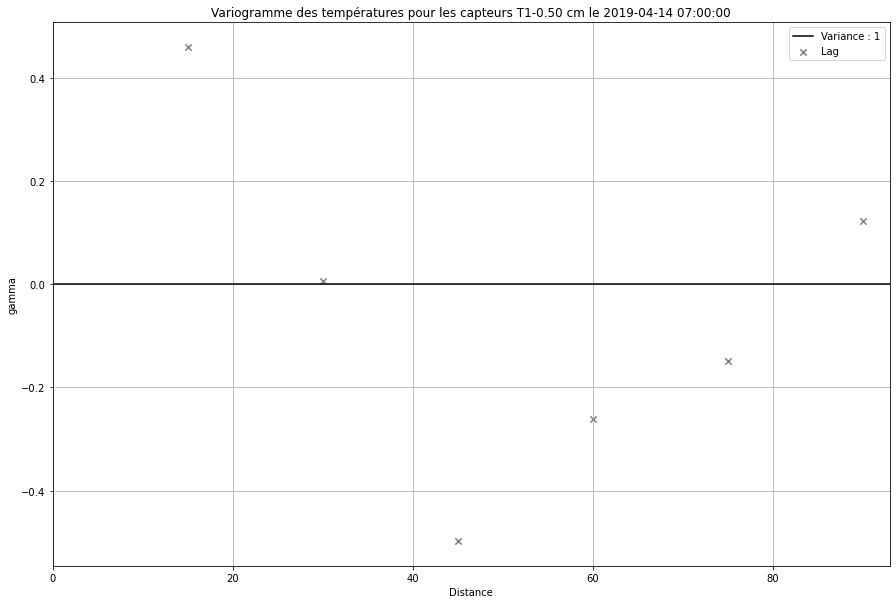

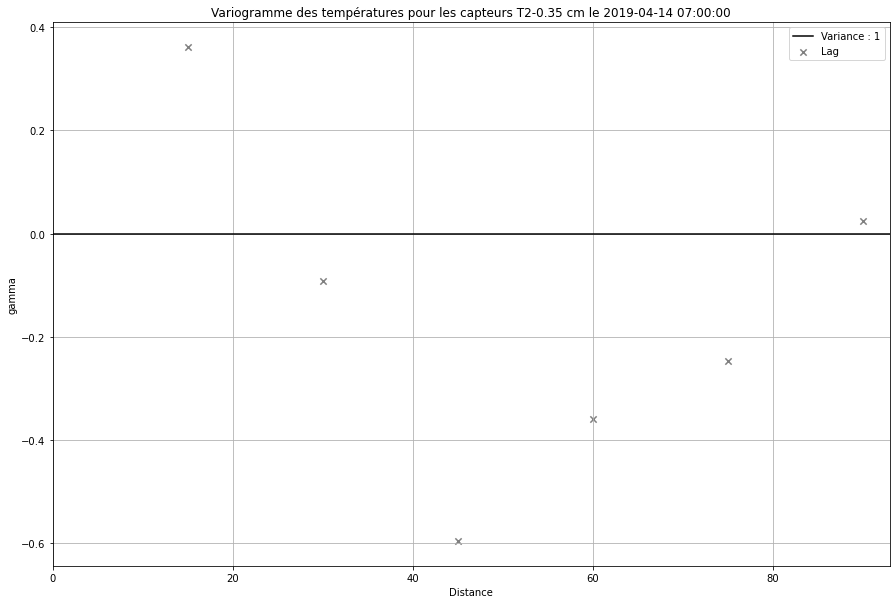

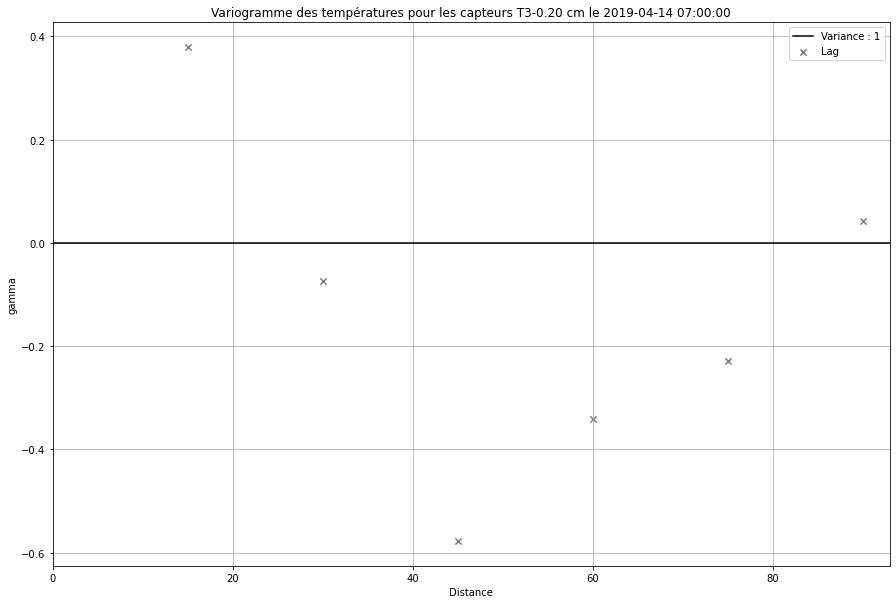

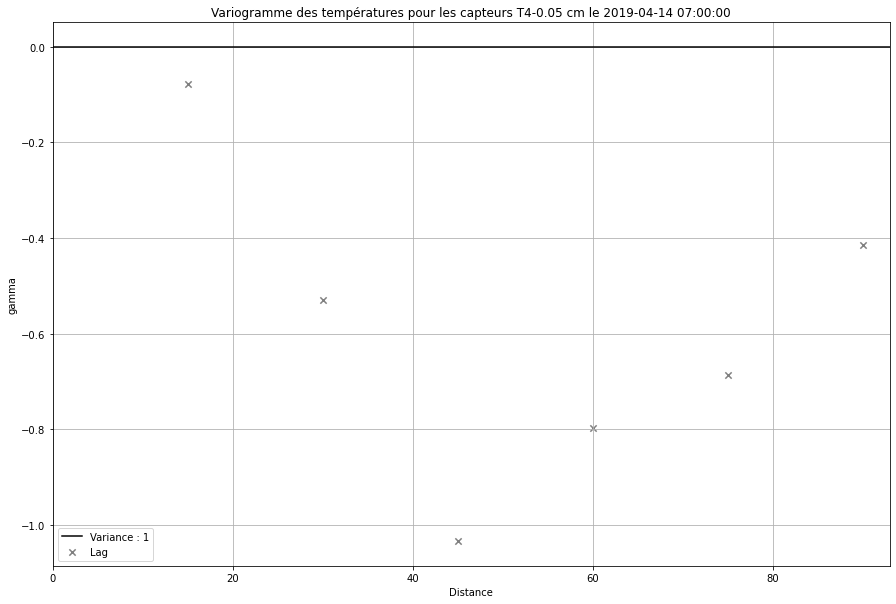

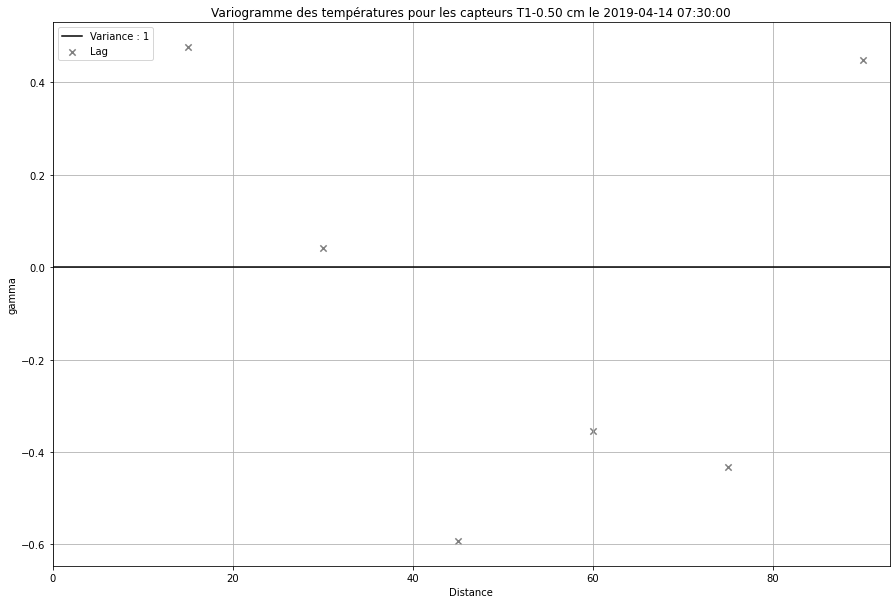

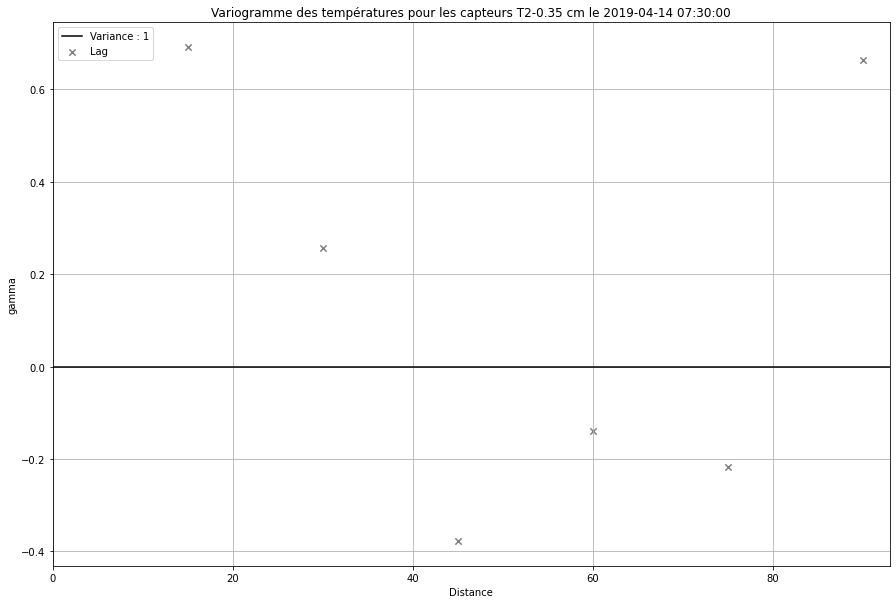

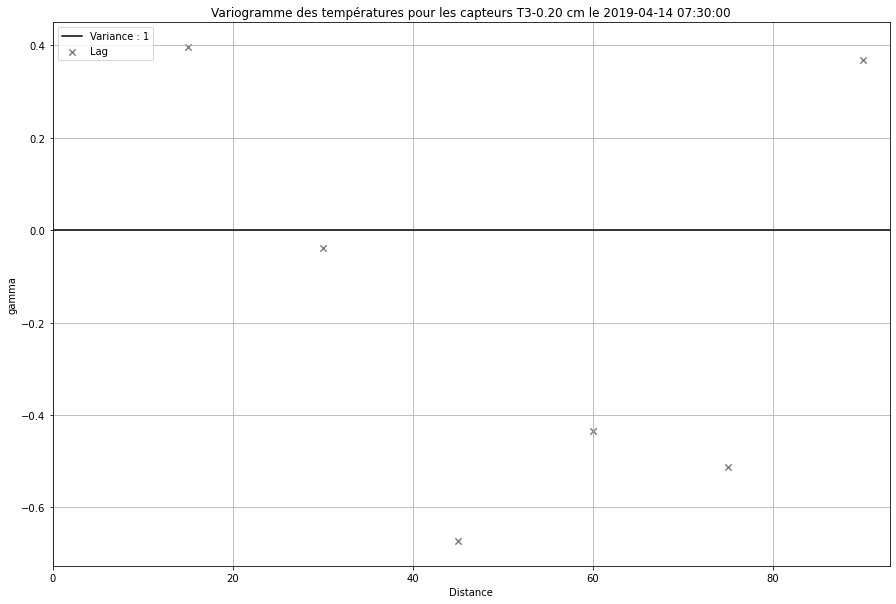

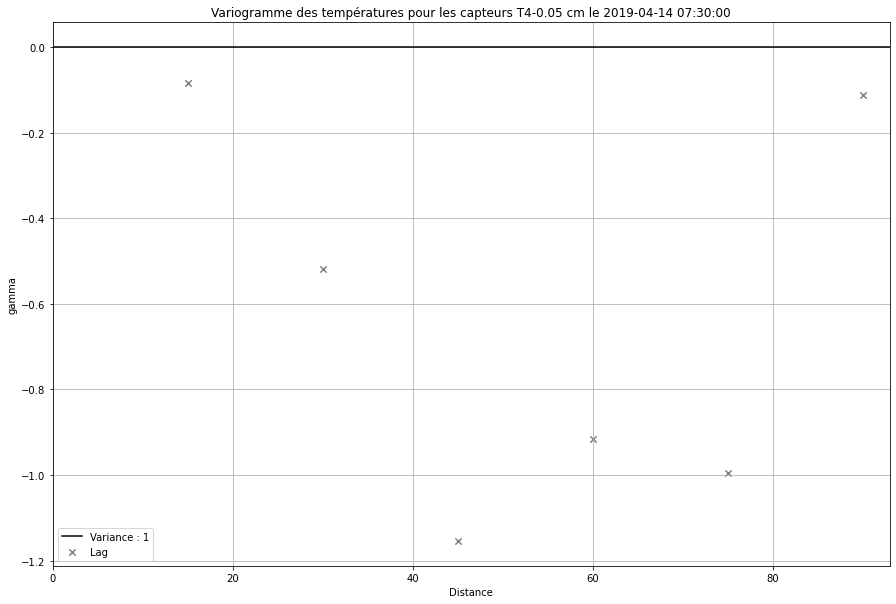

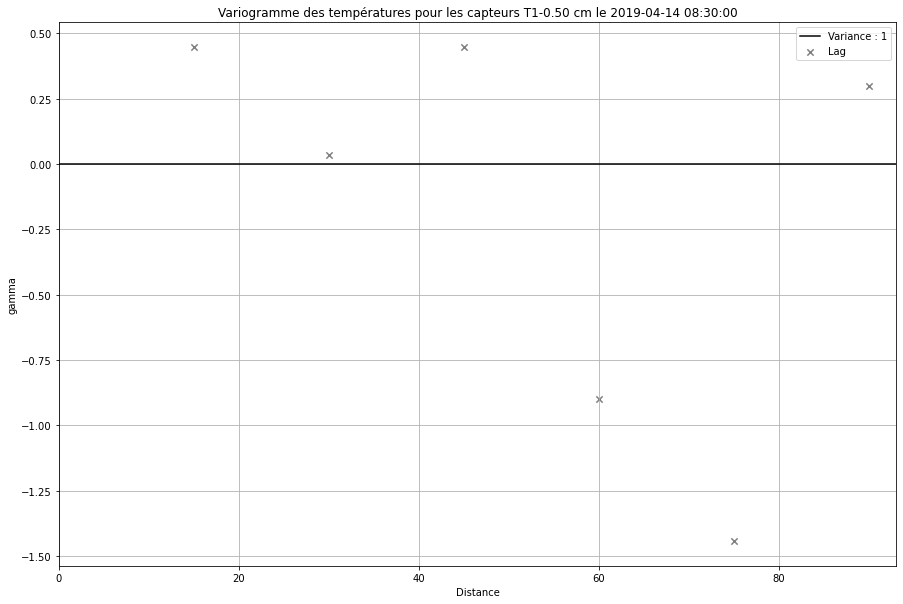

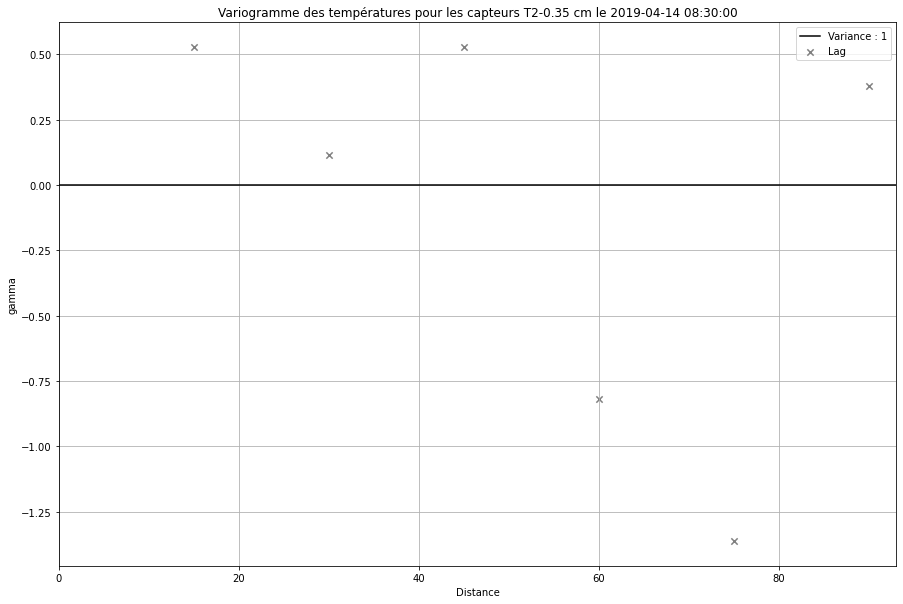

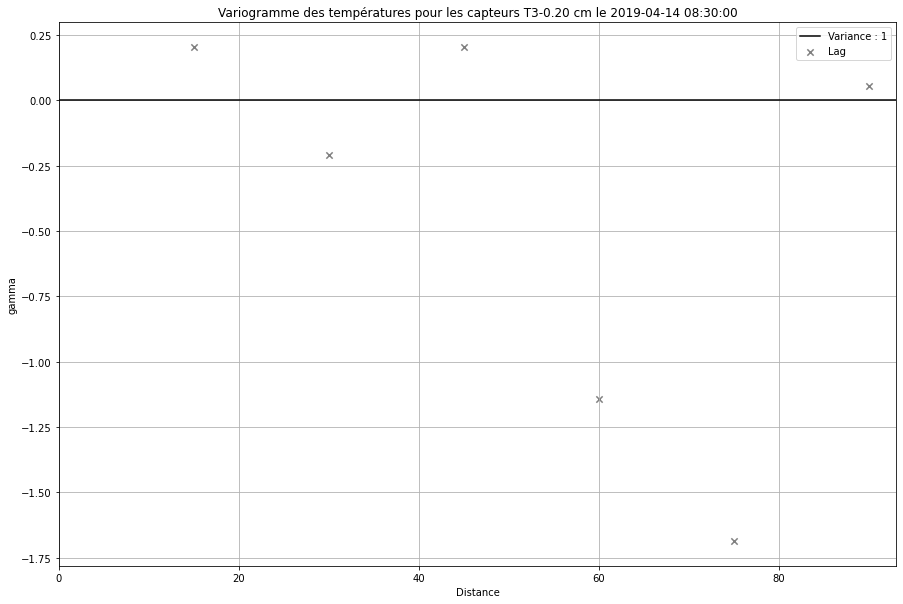

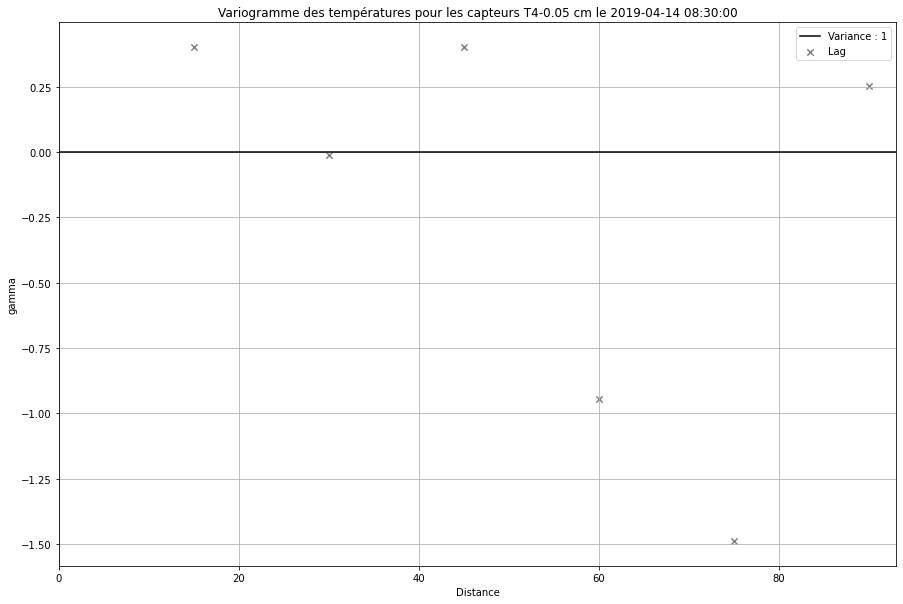

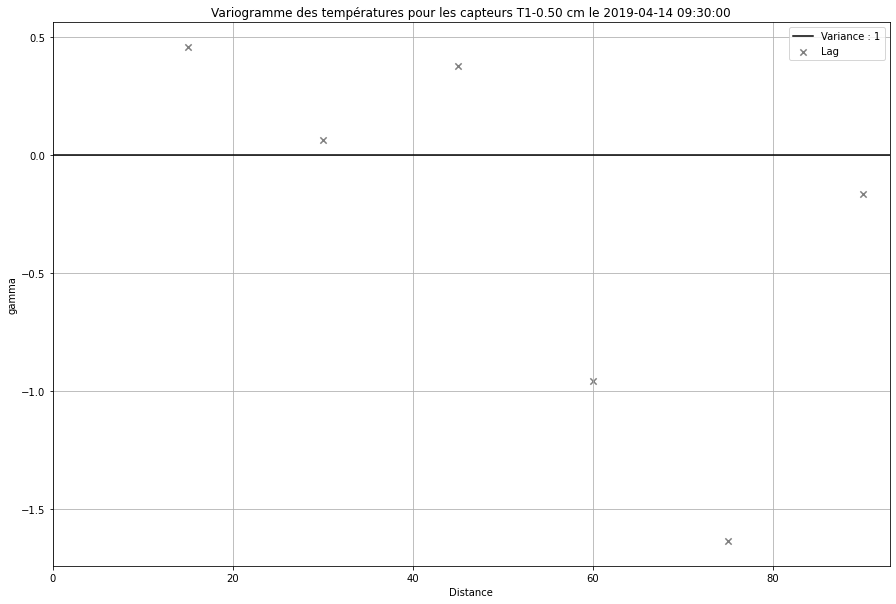

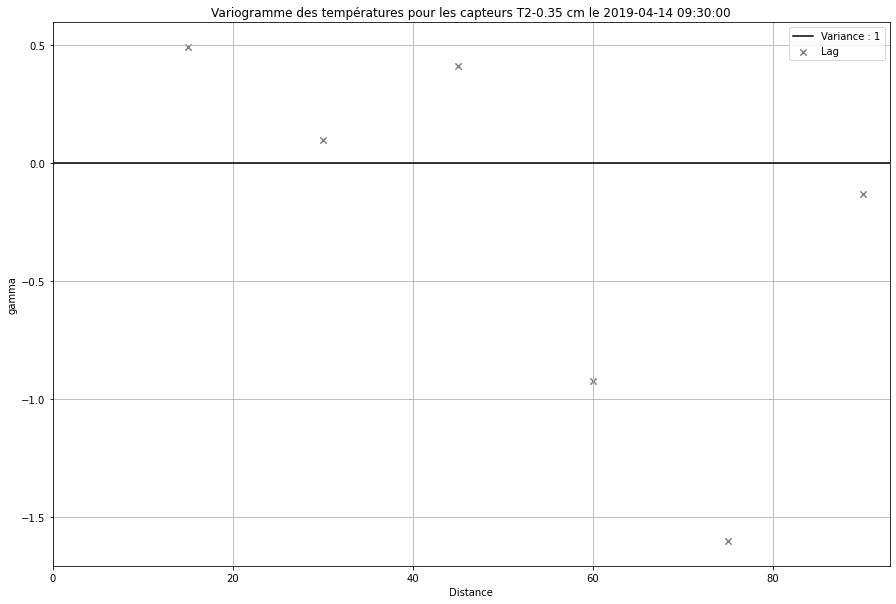

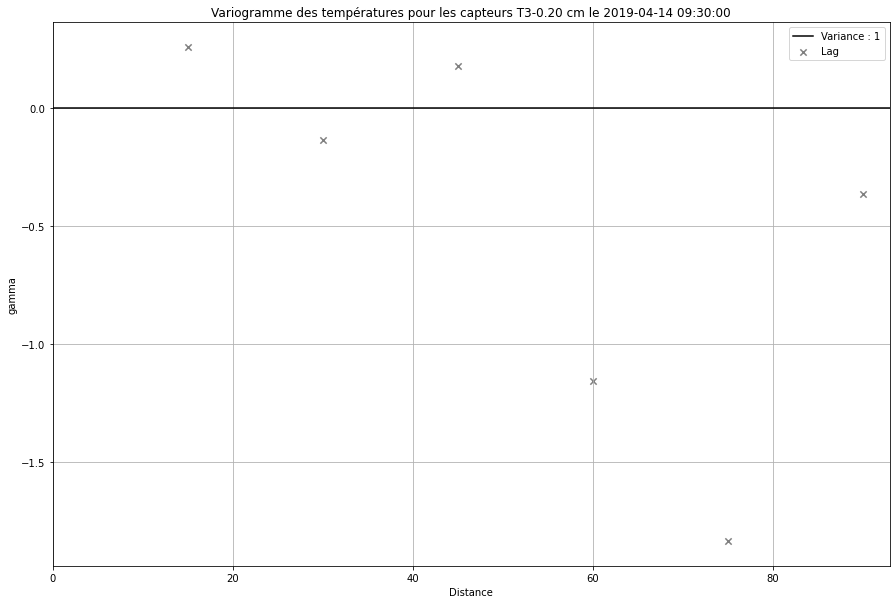

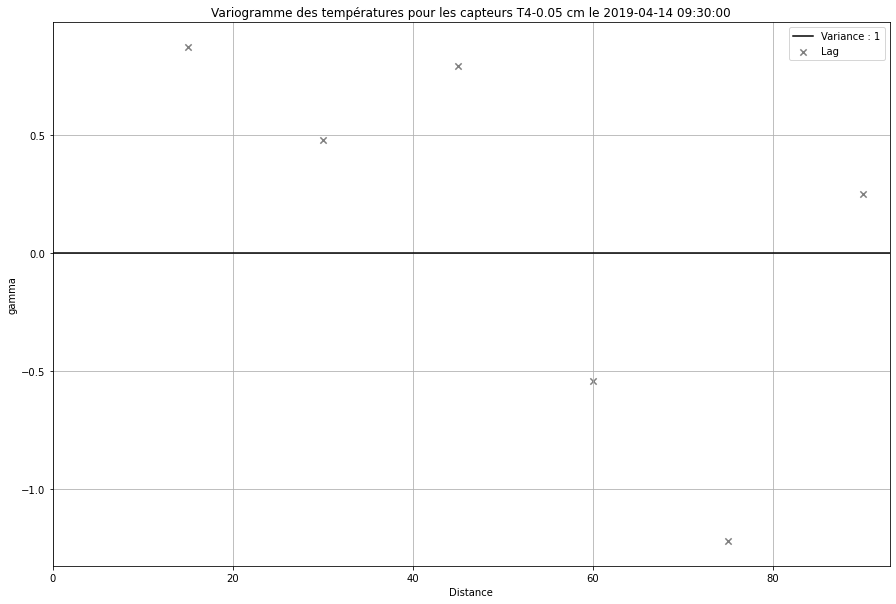

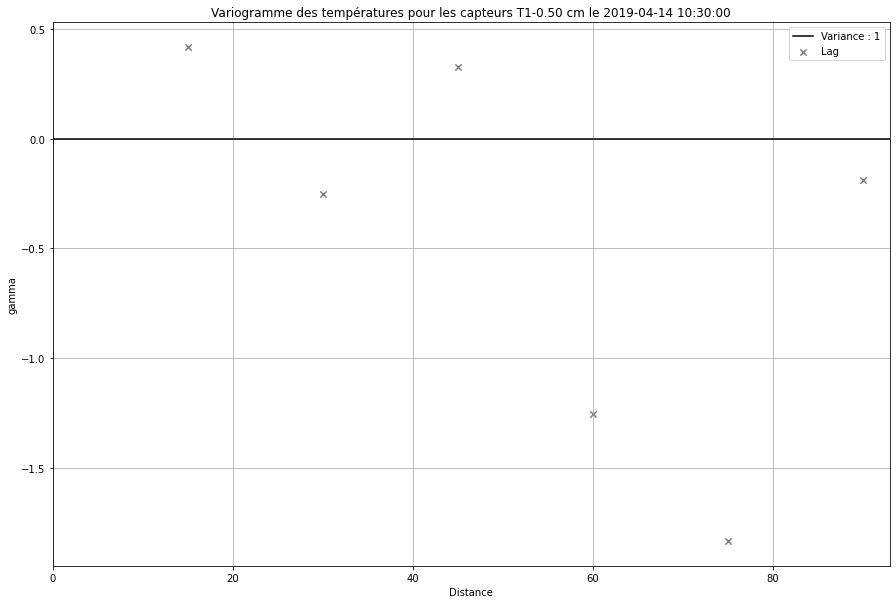

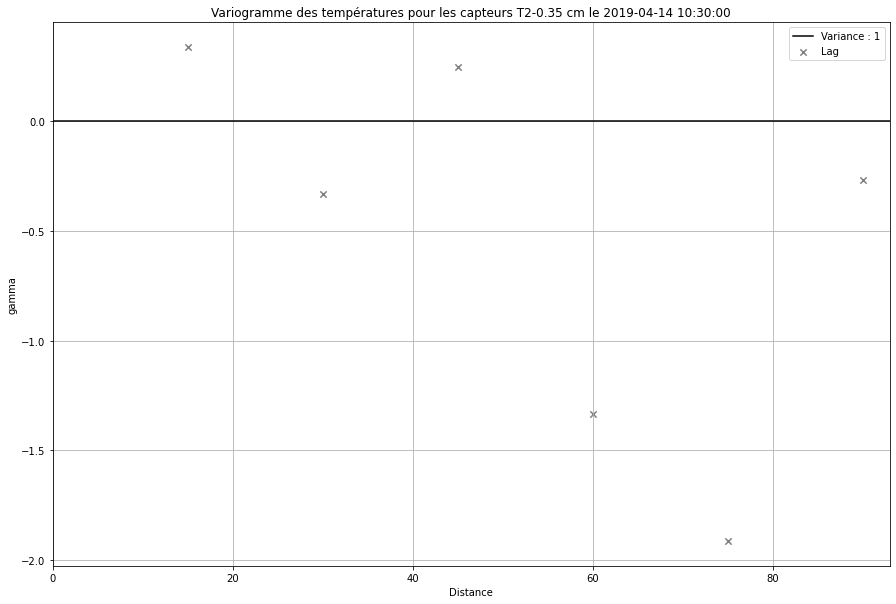

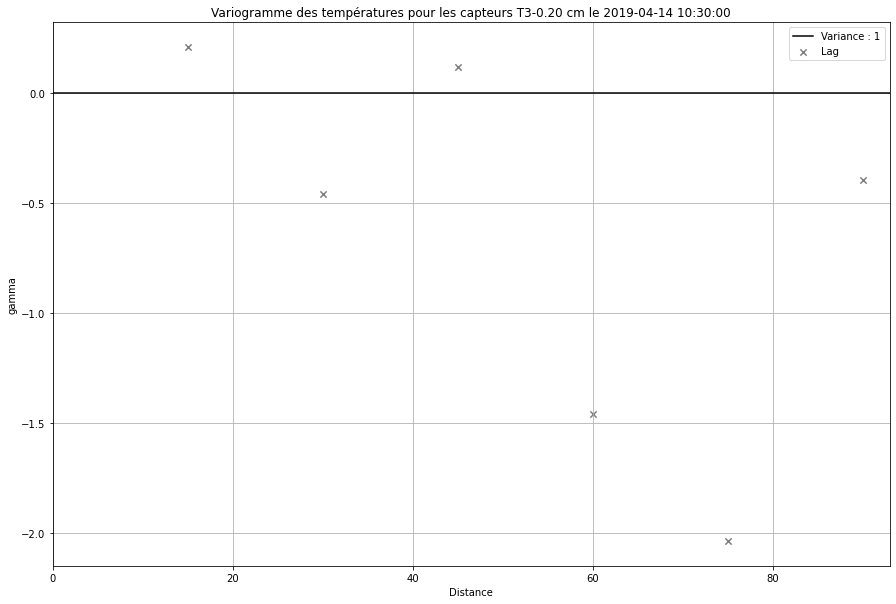

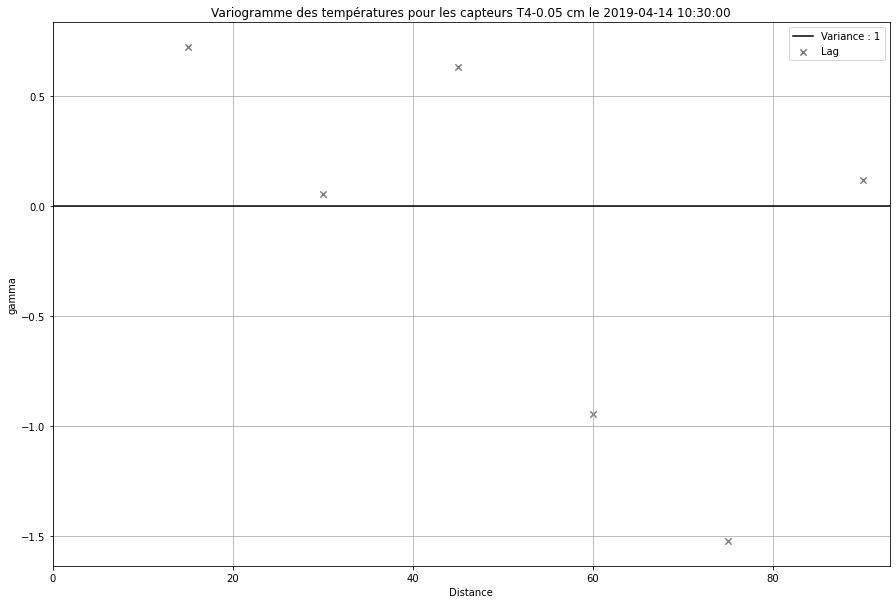

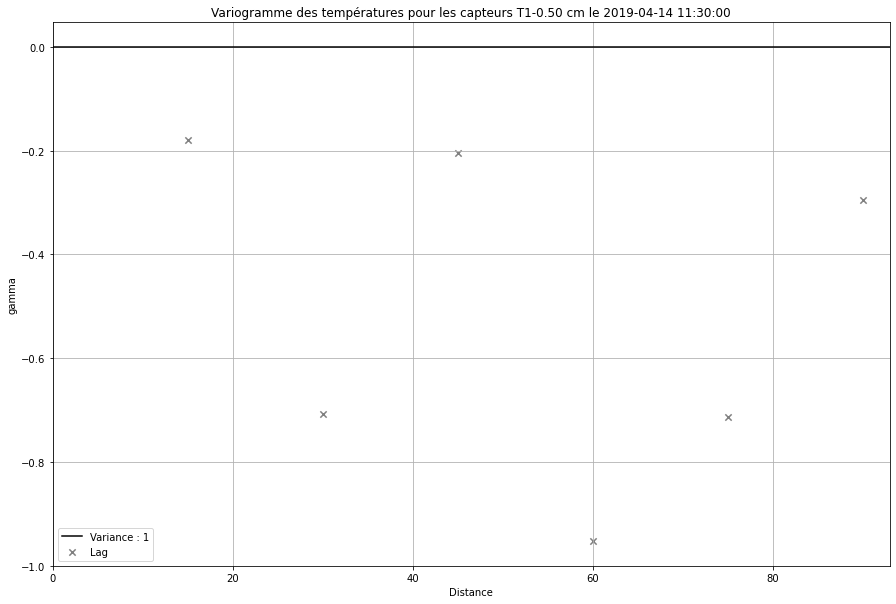

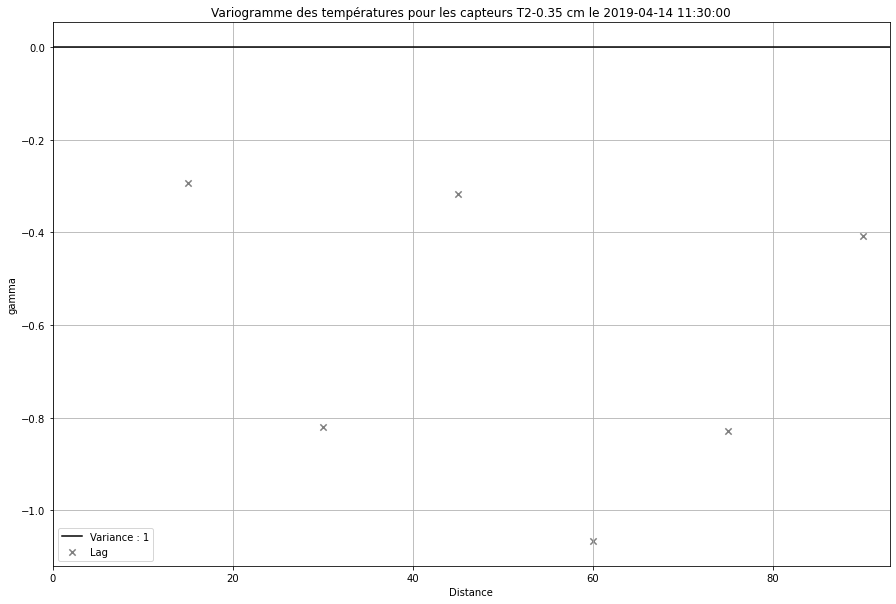

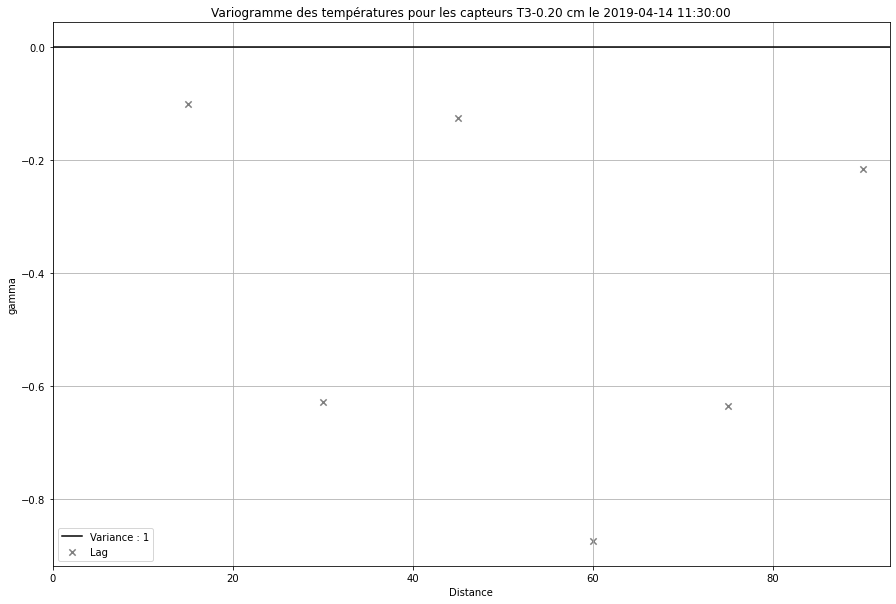

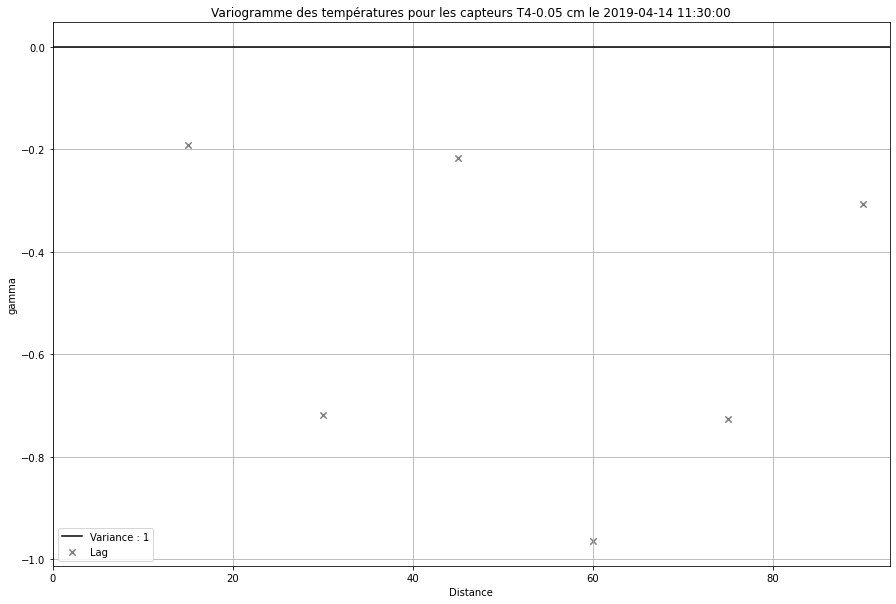

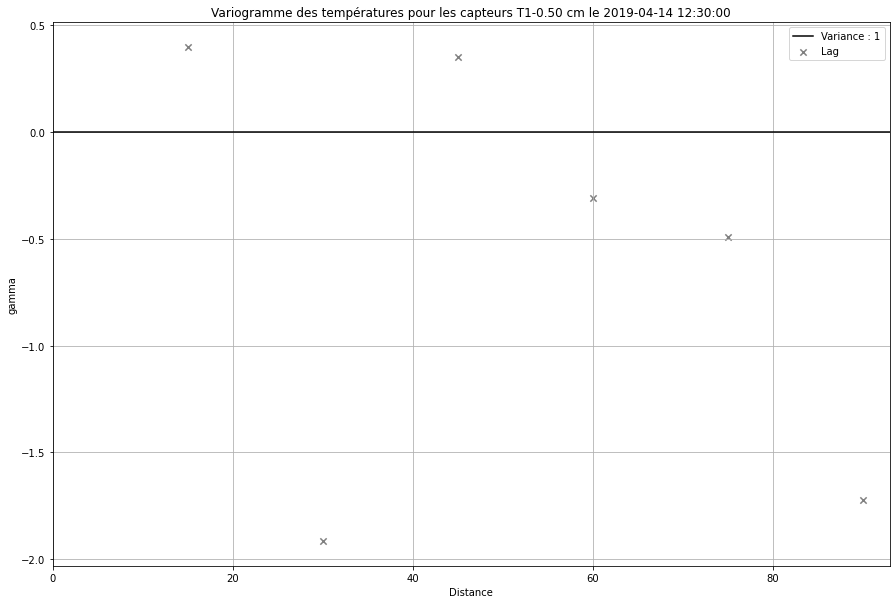

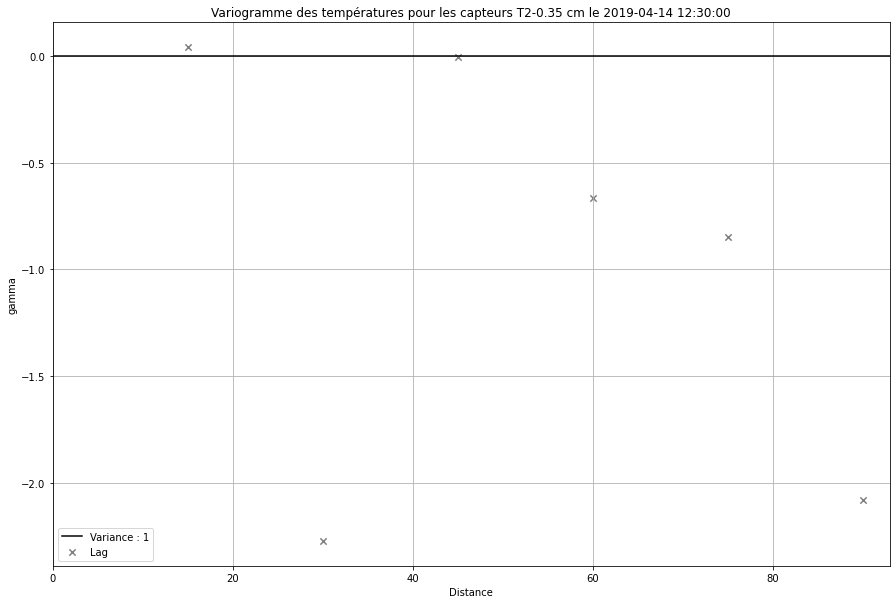

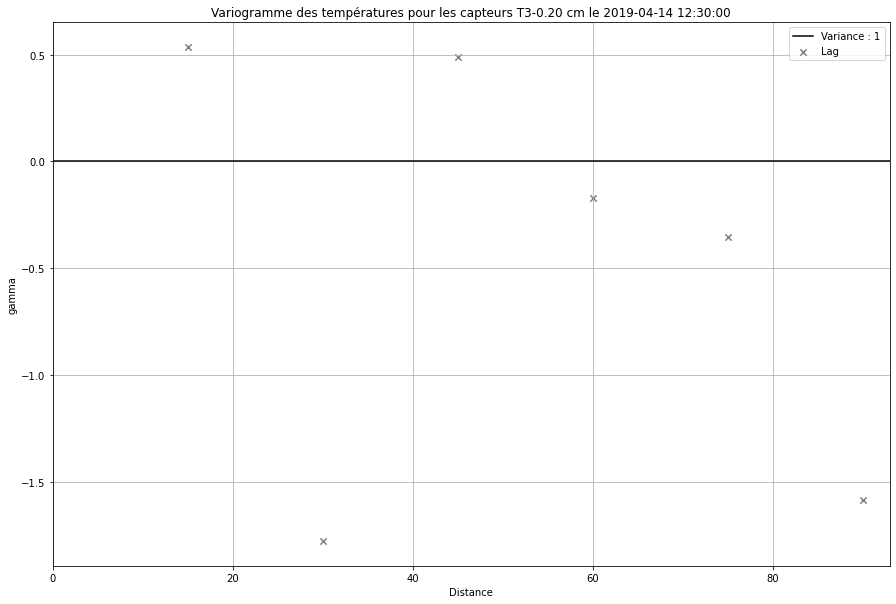

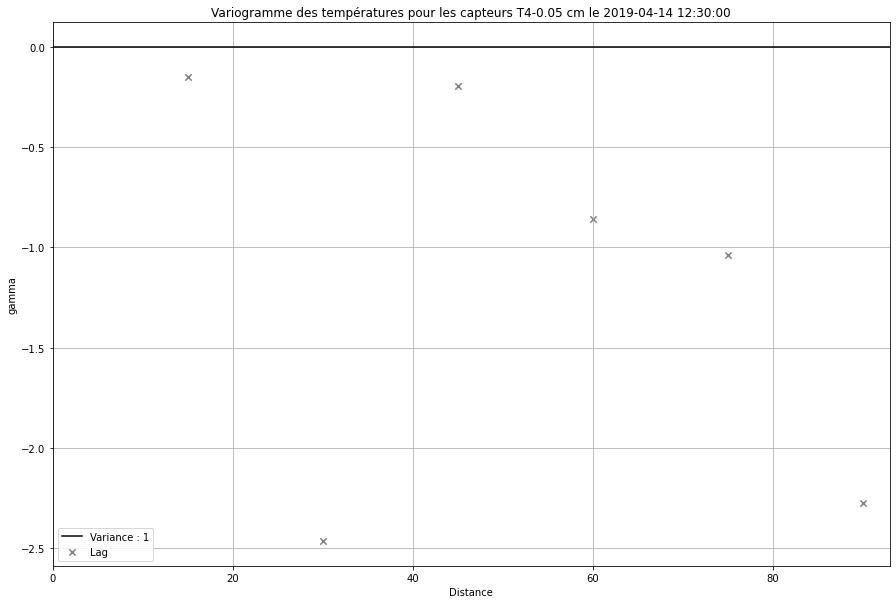

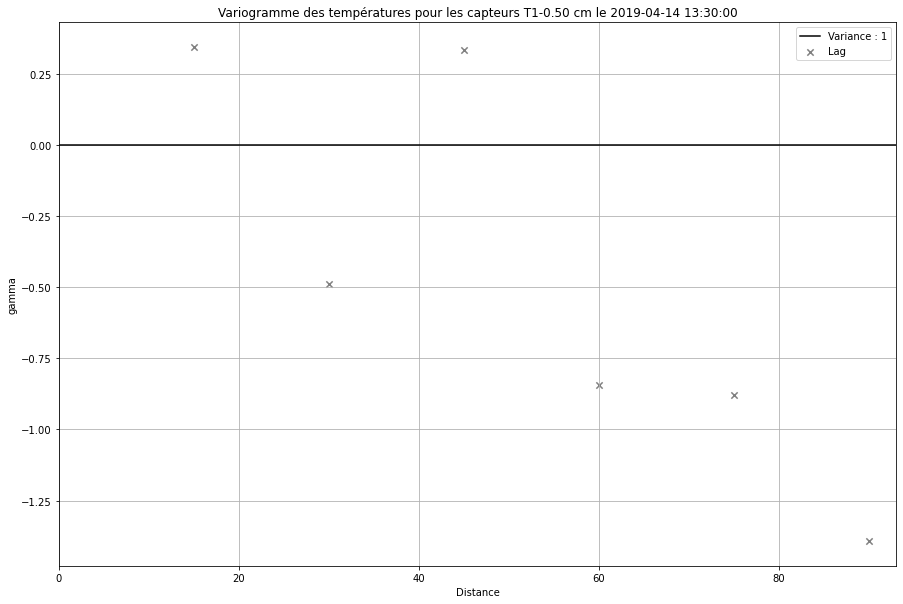

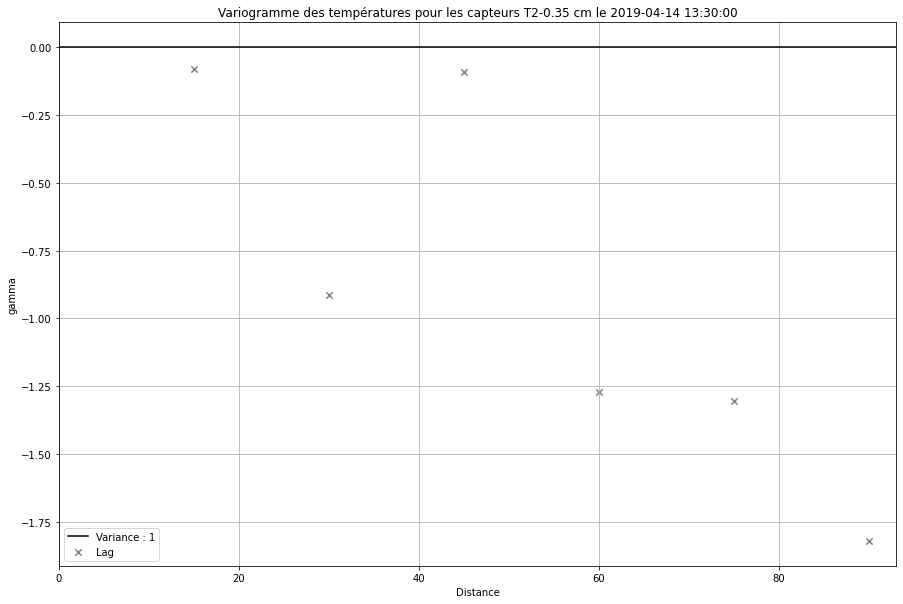

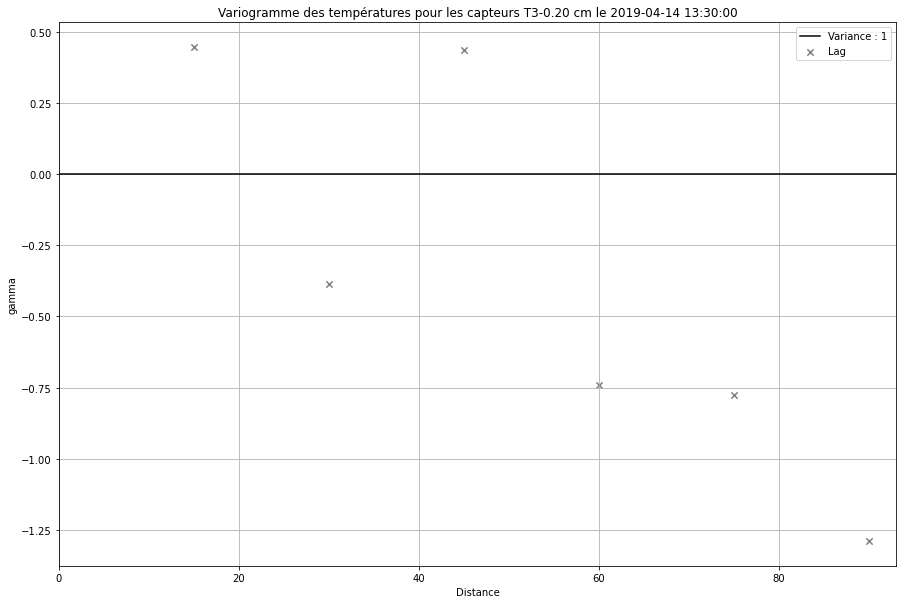

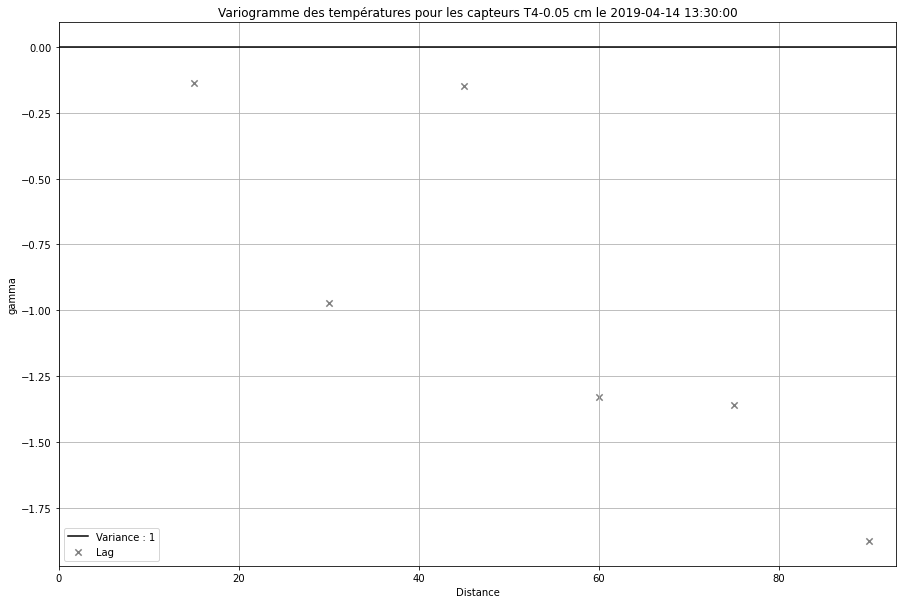

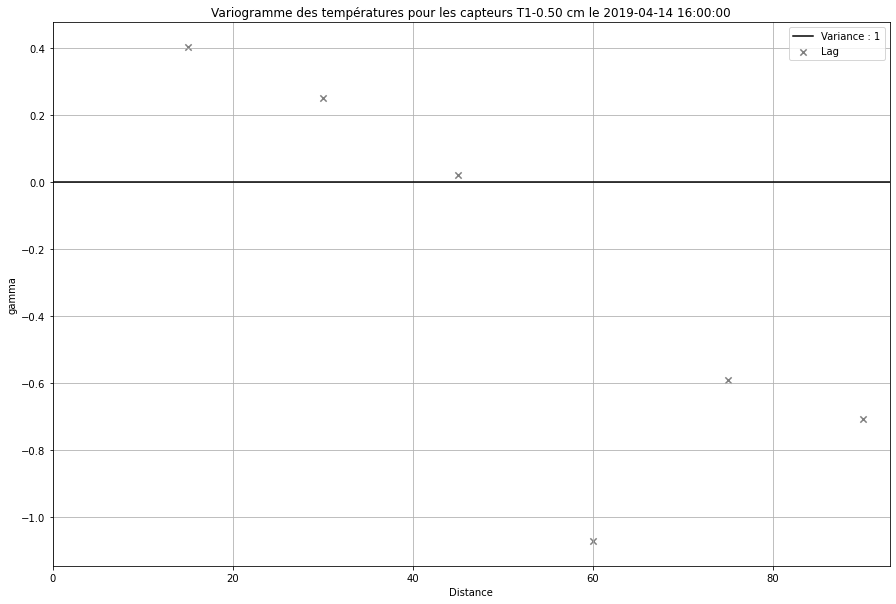

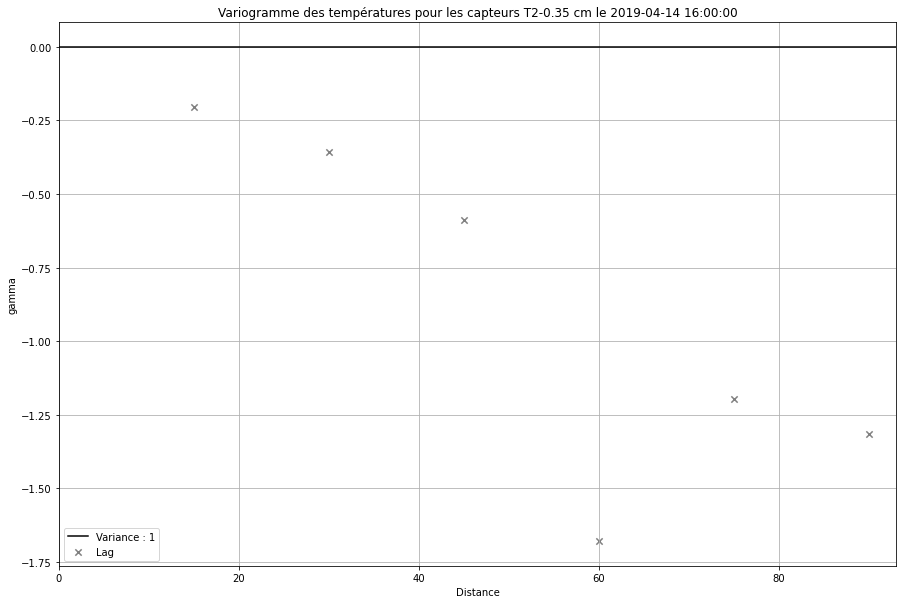

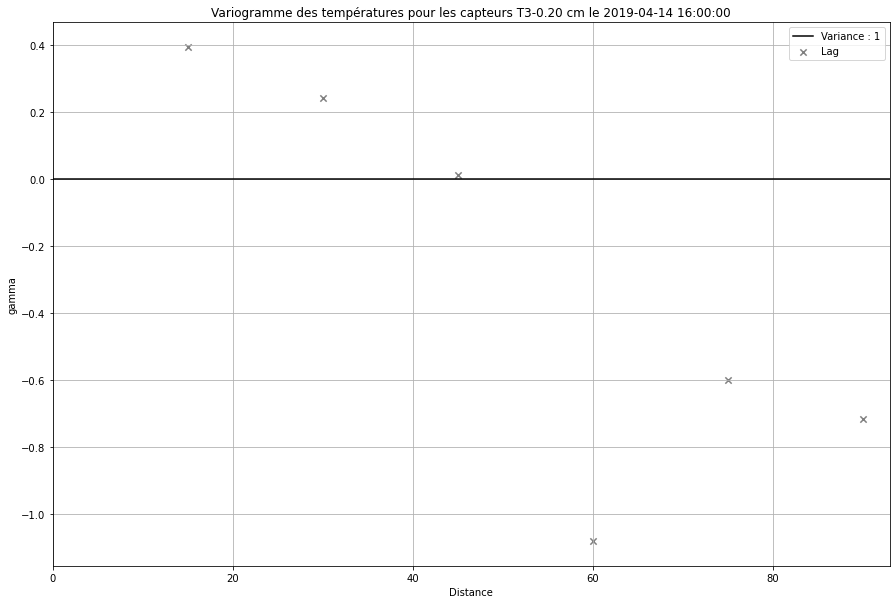

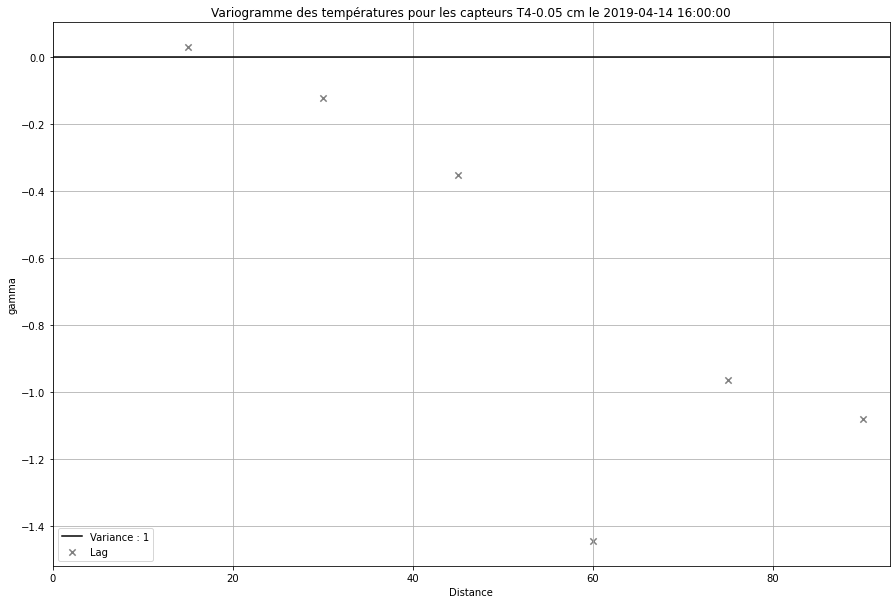

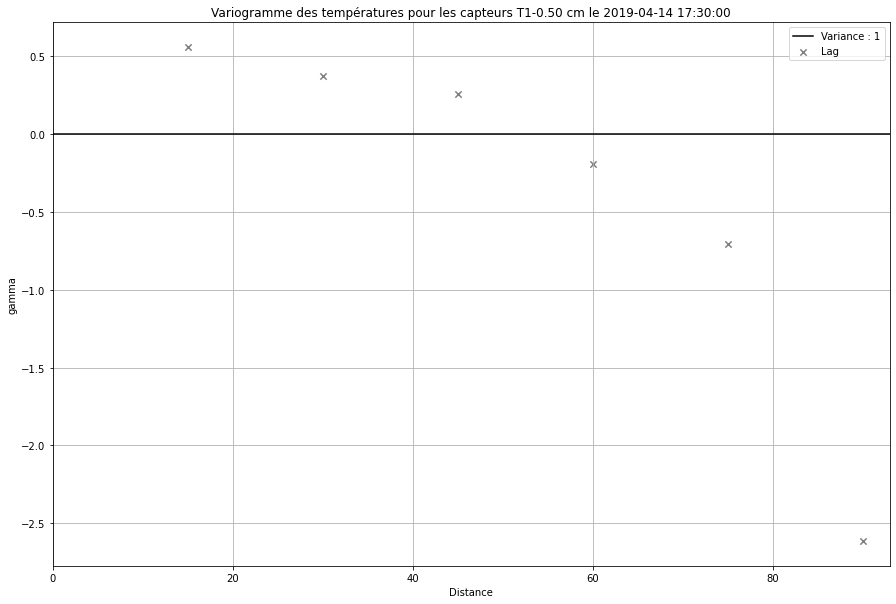

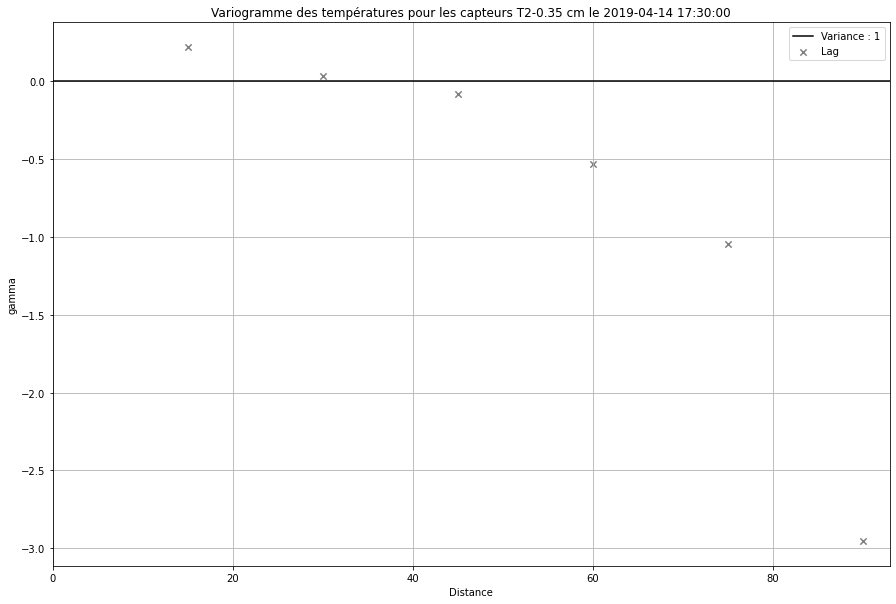

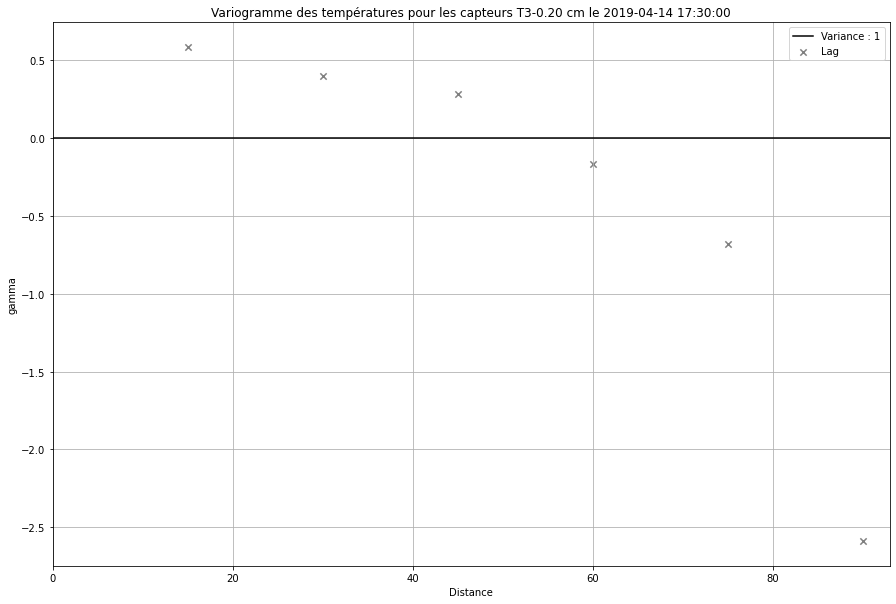

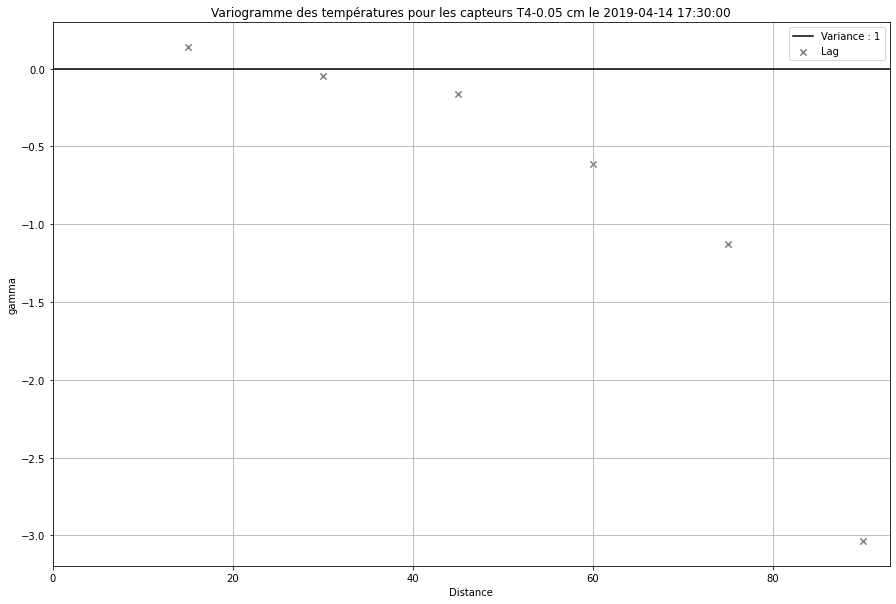

In [93]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
for REQUESTED_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        # Chemin d'accès du package correspondant à l'IR + capteur d'une sonde
        filename = "./varr/Cross_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        Cross_variogram = np.load(filename,allow_pickle='TRUE').item()
        # Timestamp de l'IR pour affichage
        IR_time = dict_PT_all_temp[REQUESTED_IR]['IR_time']
        
        #Coefficient de correlation
        corr = np.corrcoef(Cross_variogram["DataFrame"]["Primary"], Cross_variogram["DataFrame"]["Secondary"])[0, 1]
        #Nombre de pair
        dist_dir = Cross_variogram["Variogram"].loc[Cross_variogram["Variogram"]["Variogram Index"]== 1.0]["Lag Distance"].values
        # Variogram / Correlogram
        gam_dir = corr - Cross_variogram["Variogram"].loc[Cross_variogram["Variogram"]["Variogram Index"]== 1.0]["Variogram Value"].values

        # Une ligne située à la variance = 1
        ones = np.ones(shape=(100)) * 0
        H    = np.arange(0,100)
        
        fig,ax=plt.subplots(1,1,figsize = (15,10))
        LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
        sensor = str(LABEL[int(TEMP[-1])-1])
        ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
        ax.plot(H,ones,"black",label = "Variance : " + str(varr))
        ax.set_xlabel('Distance')
        ax.set_ylabel('gamma')
        ax.grid()
        ax.legend()
        ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
        ax.set_xlim([0,int(L)])


# Test avec des valeurs de Temp à +/- 15 minutes, à améliorer  

In [45]:
def variogram_primary(requested_IR,TEMP,dict_PT_all_temp,IR_time) :
    # Données sondes
    date_1='2019-04-14 06:00:00'
    date_2='2019-04-14 18:30:00'
    dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    Primary_c = reading_gps_file(filename_Sensor_txt)
    Primary_c[TEMP] = 0
    for sensor in dict_temp_sensor :
        value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
        Primary_c[TEMP].loc[Primary_c["SensorName"] == sensor] = value.values

    Primary = Primary_c.loc[Primary_c["SensorName"] != "S3-AIR"] 
    Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score

    X = Primary["x"].astype(float).values
    Y = Primary["y"].astype(float).values
    Z = Primary["Primary"].astype(float).values

    ## Distance à retenir
    distance_variable = 0
    for i in range(0,len(X)) :
        for j in range (0,len(X)) :
            x = X[i] - X[j]
            y = Y[i] - Y[j]
            dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
            if dist_temp > distance_variable :
                distance_variable = dist_temp

    ## Calcul du variogram
    L = distance_variable * 2/3
    w =15
    direction = [0]
    angle_tolerance = 90
    dist, counts, gam = {}, {}, {}

    for Dir in direction :
        st1 = timeit.default_timer()
        dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
        st2 = timeit.default_timer()
        print("RUN TIME : {0}".format(st2-st1))

    ## Save
    for direction in [1,2] :
        if direction == 1 :
            index_major = np.ones((1,len(dist[0])))
            dist_major  = dist[0]
            gam_major   = gam[0]
            count_major = counts[0]
        elif direction == 2 :
            index_minor = np.ones((1,len(dist[0]))) * 2
            dist_minor  = dist[0]
            gam_minor   = gam[0]
            count_minor = counts[0]

    index_array = np.append(index_major,index_minor)
    dist_array  = np.append(dist_major,dist_minor)
    gam_array   = np.append(gam_major,gam_minor)
    count_array   = np.append(count_major,count_minor)

    varc_1 = pd.DataFrame()
    varc_1["Lag Distance"] = dist_array
    varc_1["Number of Pairs"] = count_array
    varc_1["Variogram Value"] = gam_array
    varc_1["Variogram Index"] = index_array 

    Primary_variogram = {"DataFrame": Primary ,
                         "Variogram" : varc_1,
                         "sensor" : TEMP,
                         "IR_time" :requested_IR,
                        "Timestamp" : IR_time}

    #filename = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
    #np.save(filename,Primary_variogram)
    print("Complited :",requested_IR)
    return Primary_variogram

###  dict_variogram_min_plus : contient les variogram pour une seul profondeur / une seule IR

In [41]:
np.load("dict_PT_all_temp.npy",allow_pickle='TRUE').item().keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [44]:
dict_PT_all_temp = np.load("dict_PT_all_temp.npy",allow_pickle='TRUE').item()
IR = ["IR_6H55"]
requested_TEMP = ["T4"]
dict_variogram_min_plus = {}
Temp_label = ["plus","equal","minus"]
for requested_IR in IR :
    for TEMP in requested_TEMP :
        dict_IR_time_variation = {}
        IR_time_plus  = dict_PT_all_temp[requested_IR]['IR_time'] + pd.Timedelta("15min")
        IR_time_equal = dict_PT_all_temp[requested_IR]['IR_time']
        IR_time_minus = dict_PT_all_temp[requested_IR]['IR_time'] - pd.Timedelta("15min")
        for ii,IR_time in enumerate([IR_time_plus,IR_time_equal,IR_time_minus]) :
            print(requested_IR,TEMP,IR_time)
            Primary_variogram = variogram_primary(requested_IR,TEMP,dict_PT_all_temp,IR_time)
            dict_variogram_min_plus[Temp_label[ii]] = Primary_variogram



IR_6H55 T4 2019-04-14 07:15:00


NameError: name 'variogram_primary' is not defined

In [142]:
dict_variogram_min_plus["plus"].keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time', 'Timestamp'])

In [74]:
np.load("dict_PT_all_temp.npy",allow_pickle='TRUE').item().keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

2019-04-14 08:45:00 -> Variogram value : [0.         1.22964536 0.08214275 0.94147788 1.86754436 2.31130337]
2019-04-14 08:30:00 -> Variogram value : [0.         1.22721952 0.08309088 0.94172496 1.8711048  2.30906662]
2019-04-14 08:15:00 -> Variogram value : [0.         1.22770145 0.08519752 0.94116277 1.87187643 2.30887216]


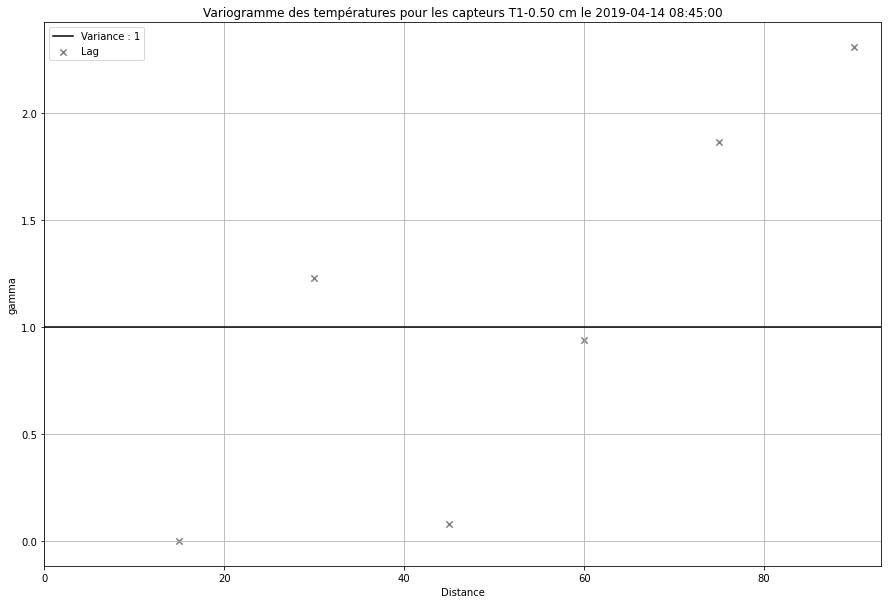

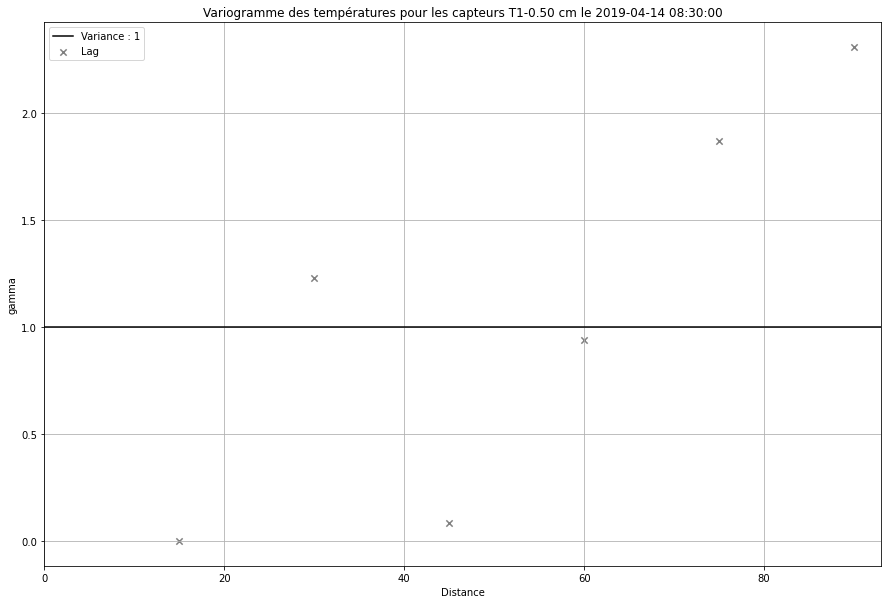

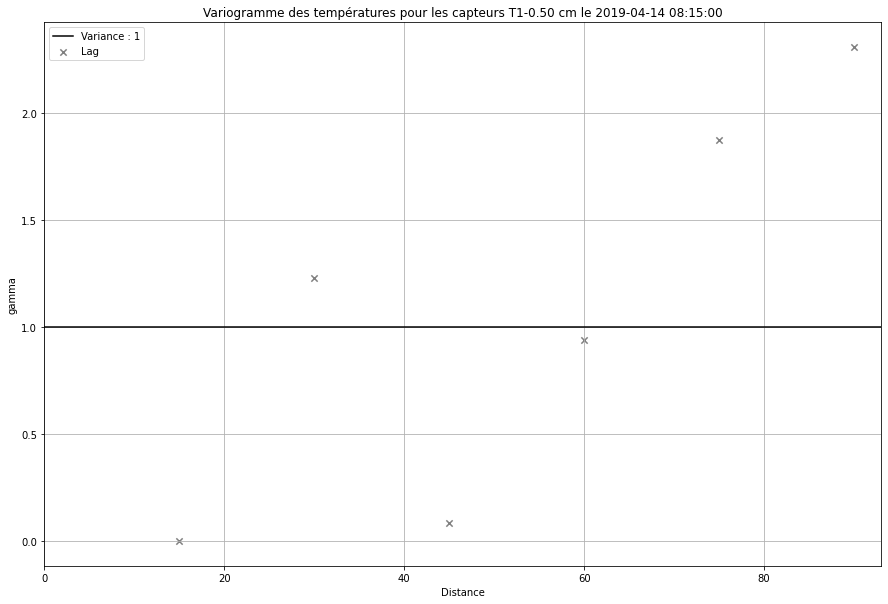

In [144]:
for time_value in dict_variogram_min_plus :
    t = dict_variogram_min_plus[time_value]["Timestamp"]
    Primary_variogram = dict_variogram_min_plus[time_value]["Variogram"]
    gam_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Variogram Value"].values
    print(t,"->","Variogram value :",gam_dir)
for time_value in dict_variogram_min_plus :
    dict_variogram_min_plus[time_value]
    IR_time = dict_variogram_min_plus[time_value]['Timestamp']
    Primary_variogram = dict_variogram_min_plus[time_value]["Variogram"]

    dist_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Lag Distance"].values
    gam_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Variogram Value"].values


    ones = np.ones(shape=(100)) * varr
    H    = np.arange(0,100)
    fig,ax=plt.subplots(1,1,figsize = (15,10))
    LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
    sensor = str(LABEL[int(TEMP[-1])-1])
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,int(L)])


## Nuée de points Variogramme 

In [137]:
def nuee_variogram(X,Y,Z) :   
    n=len(X)
    r = []
    gam_value = []
    for ii in np.arange(0,n):
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            #tht = np.arctan2(y,x) * (180/np.pi)
            r.append(np.sqrt((x)**2+(y)**2))
            gam_value.append((1/2)*(zi-zj)**2)
        
    return r,gam_value

In [135]:
r,gam_value = nuee_variogram(X,Y,Z)

Text(0.5, 1.0, ' Nuage variographique des températures pour les capteurs à 5.0 cm le 14-04-2019 07:00:00  ')

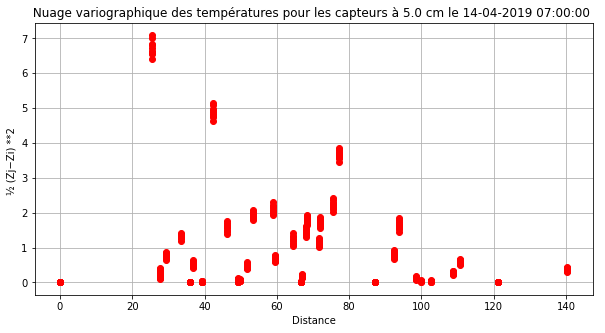

In [136]:
fig,ax=plt.subplots(1,1, figsize = (10,5))
ax.plot(r,gam_value,"ro")
ax.set_xlabel('Distance')
ax.set_ylabel('½ (Zj−Zi) **2 ')
ax.grid()
ax.set_title(" Nuage variographique des températures pour les capteurs à 5.0 cm le 14-04-2019 07:00:00  ")